# Log

- with a weight of 0.01 and 'different' contexts it seem to move towards the right distribution; same does not happen when the contexts are the same

In [1]:
#!pip install nflows

In [2]:
#!pip install zuko

In [3]:
#pip install git+https://github.com/valsdav/zuko.git

In [4]:
import os
import sys
sys.path.insert(0, '/eos/home-g/gallim/SWAN_projects/test_gpu/zuko')
print(os.environ['PYTHONPATH'])

/usr/local/lib/swan/extensions/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/itk:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/python:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages


In [5]:
import zuko

In [6]:
zuko.__file__

'/eos/home-g/gallim/SWAN_projects/test_gpu/zuko/zuko/__init__.py'

In [7]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.pipeline import Pipeline

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import nflows
from nflows import flows, transforms
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.distributions.uniform import BoxUniform, MG1Uniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet
import zuko

np.random.seed(100)
print(torch.cuda.is_available())

True


In [8]:
print(torch.cuda.current_device())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

0
cuda


In [9]:
class MyDataset(Dataset):
    def __init__(
        self,
        dataframe,
        context_variables,
        target_variables,
        device=None,
        rows=None,
    ):
        self.context_variables = context_variables
        self.target_variables = target_variables
        self.all_variables = context_variables + target_variables
        data = dataframe
        if rows is not None:
            data = data.iloc[:rows]
        self.target = data[target_variables].values
        self.context = data[context_variables].values
        if device is not None:
            self.target = torch.tensor(self.target, dtype=torch.float32).to(device)
            self.context = torch.tensor(self.context, dtype=torch.float32).to(device)

    def __len__(self):
        assert len(self.context) == len(self.target)
        return len(self.target)

    def __getitem__(self, idx):
        return self.context[idx], self.target[idx]

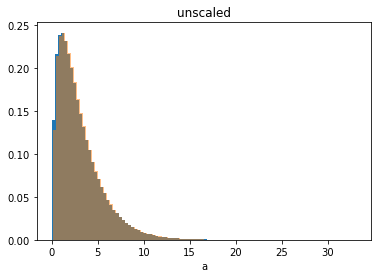

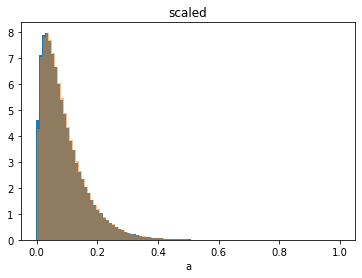

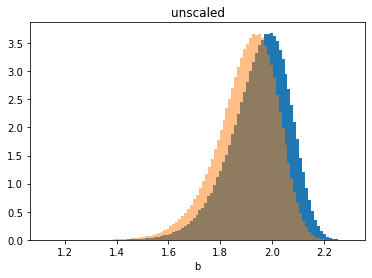

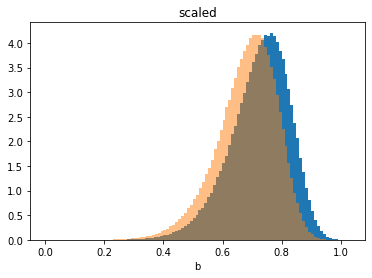

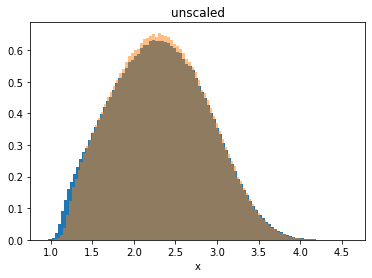

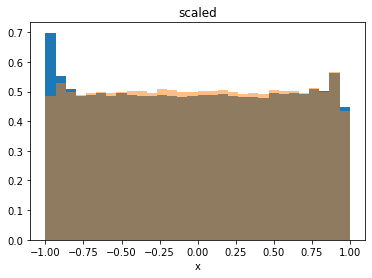

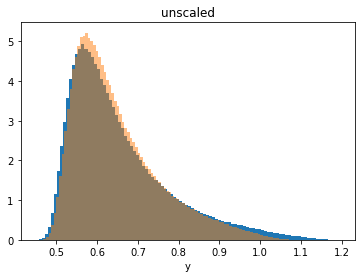

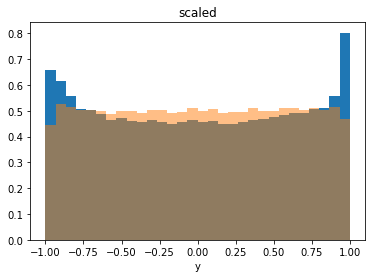

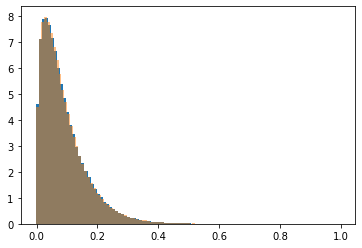

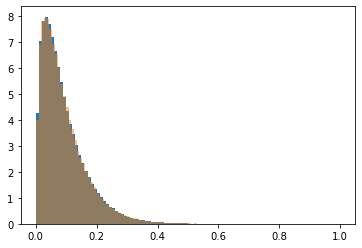

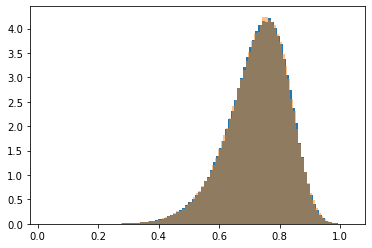

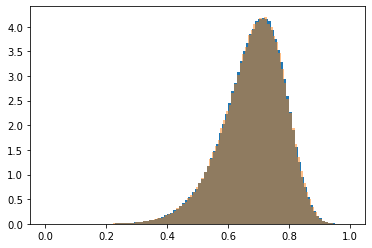

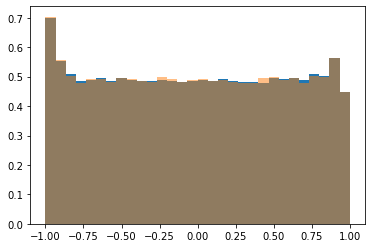

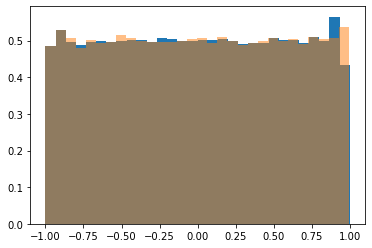

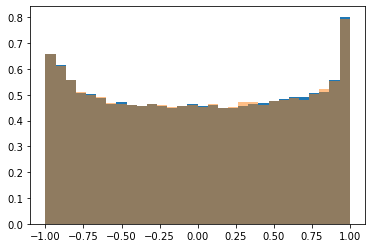

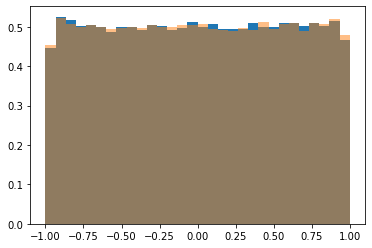

In [10]:
pipelines = {
    'a': Pipeline([("scaler", MinMaxScaler((0, 1)))]),
    'b': Pipeline([("scaler", MinMaxScaler((0, 1)))]),
    'x': Pipeline(
        [
            ("qt", QuantileTransformer(n_quantiles=30)),
            ("scaler", MinMaxScaler((-1, 1)))
        ],
    ),
    'y': Pipeline(
        [
            ("qt", QuantileTransformer(n_quantiles=30)),
            ("scaler", MinMaxScaler((-1, 1)))            
        ]
    ),
}

nevs = 1000000
dof = 3
qt_bins = 30
pdf1 = chi2(dof)
sample1 = pdf1.rvs(nevs)
sample1_target = sample1 + 0.1 + 0.01 * np.random.normal(size=sample1.shape)
plt.hist(sample1, bins=100, density=True)
plt.hist(sample1_target, bins=100, alpha=0.5, density=True)
plt.title('unscaled')
plt.xlabel('a')
plt.show()
sample1_original = deepcopy(sample1)
sample1_target_original = deepcopy(sample1_target)
sample1_target = pipelines['a'].fit_transform(sample1_target.reshape(-1, 1)).reshape(-1)
sample1 = pipelines['a'].transform(sample1.reshape(-1, 1)).reshape(-1)
sample1_train, sample1_test = train_test_split(sample1, test_size=0.3)
sample1_target_train, sample1_target_test = train_test_split(sample1_target, test_size=0.3)
plt.hist(sample1_train, bins=100, density=True)
plt.hist(sample1_target_train, bins=100, alpha=0.5, density=True)
plt.title('scaled')
plt.xlabel('a')
plt.show()

pdf2 = weibull_min(10, 1)
sample2 = pdf2.rvs(nevs)
sample2_target = sample2 - 0.05 + 0.01 * np.random.normal(size=sample2.shape)
plt.hist(sample2, bins=100, density=True)
plt.hist(sample2_target, bins=100, alpha=0.5, density=True)
plt.title('unscaled')
plt.xlabel('b')
plt.show()
sample2_original = deepcopy(sample2)
sample2_target_original = deepcopy(sample2_target)
sample2_target = pipelines['b'].fit_transform(sample2_target.reshape(-1, 1)).reshape(-1)
sample2 = pipelines['b'].transform(sample2.reshape(-1, 1)).reshape(-1)
sample2_train, sample2_test = train_test_split(sample2, test_size=0.3)
sample2_target_train, sample2_target_test = train_test_split(sample2_target, test_size=0.3)
plt.hist(sample2_train, bins=100, density=True)
plt.hist(sample2_target_train, bins=100, alpha=0.5, density=True)
plt.title('scaled')
plt.xlabel('b')
plt.show()

# now produce three samples that are related to both pdf1, pdf2 and each other
sample3 = np.log1p(sample1_original) + np.log1p(sample2_original)
sample3_target = np.log1p(sample1_target_original) + np.log1p(sample2_target_original)
#sample3_target = QuantileTransformer(output_distribution='normal').fit_transform(sample3_target.reshape(-1, 1)).reshape(-1)
#sample3_target = MinMaxScaler((0, 1)).fit_transform(sample3_target.reshape(-1, 1)).reshape(-1)
plt.hist(sample3, bins=100, density=True)
plt.hist(sample3_target, bins=100, alpha=0.5, density=True)
plt.title('unscaled')
plt.xlabel('x')
plt.show()
sample3_original = deepcopy(sample3)
sample3_target_original = deepcopy(sample3_target)
sample3_target = pipelines['x'].fit_transform(sample3_target.reshape(-1, 1)).reshape(-1)
sample3 = pipelines['x'].transform(sample3.reshape(-1, 1)).reshape(-1)
sample3_train, sample3_test = train_test_split(sample3, test_size=0.3)
sample3_target_train, sample3_target_test = train_test_split(sample3_target, test_size=0.3)
plt.hist(sample3_train, bins=qt_bins, density=True)
plt.hist(sample3_target_train, bins=qt_bins, alpha=0.5, density=True)
plt.title('scaled')
plt.xlabel('x')
plt.show()

sample4 = np.log1p(sample1_original) + np.log1p(sample2_original) - np.log1p(sample1_original * sample2_original) + 0.05
sample4_target = np.log1p(sample1_target_original) + np.log1p(sample2_target_original) - np.log1p(sample1_target_original * sample2_target_original) + 0.05
#sample4_target = QuantileTransformer(output_distribution='normal').fit_transform(sample4_target.reshape(-1, 1)).reshape(-1)
#sample4_target = MinMaxScaler((0, 1)).fit_transform(sample4_target.reshape(-1, 1)).reshape(-1)
plt.hist(sample4, bins=100, density=True)
plt.hist(sample4_target, bins=100, alpha=0.5, density=True)
plt.title('unscaled')
plt.xlabel('y')
plt.show()
sample4_target = pipelines['y'].fit_transform(sample4_target.reshape(-1, 1)).reshape(-1)
sample4 = pipelines['y'].transform(sample4.reshape(-1, 1)).reshape(-1)
sample4_train, sample4_test = train_test_split(sample4, test_size=0.3)
sample4_target_train, sample4_target_test = train_test_split(sample4_target, test_size=0.3)
plt.hist(sample4_train, bins=qt_bins, density=True)
plt.hist(sample4_target_train, bins=qt_bins, alpha=0.5, density=True)
plt.title('scaled')
plt.xlabel('y')
plt.show()

df = pd.DataFrame({'a': sample1_train, 'b': sample2_train, 'x': sample3_train, 'y': sample4_train})
df_target = pd.DataFrame({'a': sample1_target_train, 'b': sample2_target_train, 'x': sample3_target_train, 'y': sample4_target_train})

df_test = pd.DataFrame({'a': sample1_test, 'b': sample2_test, 'x': sample3_test, 'y': sample4_test})
df_target_test = pd.DataFrame({'a': sample1_target_test, 'b': sample2_target_test, 'x': sample3_target_test, 'y': sample4_target_test})

plt.hist(df['a'], bins=100, density=True)
plt.hist(df_test['a'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['a'], bins=100, density=True)
plt.hist(df_target_test['a'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df['b'], bins=100, density=True)
plt.hist(df_test['b'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['b'], bins=100, density=True)
plt.hist(df_target_test['b'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df['x'], bins=qt_bins, density=True)
plt.hist(df_test['x'], bins=qt_bins, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['x'], bins=qt_bins, density=True)
plt.hist(df_target_test['x'], bins=qt_bins, density=True, alpha=0.5)
plt.show()
plt.hist(df['y'], bins=qt_bins, density=True)
plt.hist(df_test['y'], bins=qt_bins, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['y'], bins=qt_bins, density=True)
plt.hist(df_target_test['y'], bins=qt_bins, density=True, alpha=0.5)
plt.show()

In [11]:
context_vars = ['a', 'b']
input_vars = ['x', 'y']
rows = 100000
rows_test = 100000
batch_size = 1000
print(len(df), len(df_test))
mc_dataset_train = MyDataset(df, context_vars, input_vars, device=device, rows=rows)
mc_loader_train = DataLoader(mc_dataset_train, batch_size=batch_size)
data_dataset_train = MyDataset(df_target, context_vars, input_vars, device=device, rows=rows)
data_loader_train = DataLoader(data_dataset_train, batch_size=batch_size)
mc_dataset_test = MyDataset(df_test, context_vars, input_vars, device=device, rows=rows_test)
mc_loader_test = DataLoader(mc_dataset_test, batch_size=batch_size)
data_dataset_test = MyDataset(df_target_test, context_vars, input_vars, device=device, rows=rows_test)
data_loader_test = DataLoader(data_dataset_test, batch_size=batch_size)

700000 300000


In [12]:
mc_dataset_train.context.get_device()

0

# Train bases

In [13]:
import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform, DiagNormal

In [14]:
ninput = 2
ncontext = 2

epochs = 60
plot_every = 5

def build_flow(features, ntransforms=4, context=None, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    flow = zuko.flows.NSF(features, context=context, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes= 2 if not autoregressive else features)

    #flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
    #                                             -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow


def make_base_flow_and_train(loader, test_loader, df_test):
    flow = build_flow(features=ninput, ntransforms=3, context=ncontext, hidden_mlp=[16], bins=30, autoregressive=True)
    flow = flow.to(device)
    optimizer = optim.Adam(flow.parameters())

    train_history, test_history = [], []
    for epoch in range(epochs + 1):
        print(epoch)
        train_losses, test_losses = [], []

        # train
        for ab, xy in loader:
            loss = -flow(ab).log_prob(xy).mean()
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_train_loss = np.mean(train_losses)
        train_history.append(epoch_train_loss)
        print(train_history)

        # test
        print('testing')
        for ab, xy in test_loader:
            with torch.no_grad():
                loss = -flow(ab).log_prob(xy).mean()
                test_losses.append(loss.item())
        
        epoch_test_loss = np.mean(test_losses)
        test_history.append(epoch_test_loss)

        if epoch % plot_every == 0:
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
            a, b, x, y = df_test['a'].values, df_test['b'].values, df_test['x'].values, df_test['y'].values
            xy_sample = flow(torch.tensor(df_test[['a', 'b']].values, dtype=torch.float32).to(device)).sample((1,)).to(device).reshape(-1, ninput)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()
            x_min = min(x.min(), x_sample.min())
            x_max = max(x.max(), x_sample.max())
            ax1.hist(x, bins=qt_bins, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=qt_bins, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            y_min = min(y.min(), y_sample.min())
            y_max = max(y.max(), y_sample.max())
            ax1.legend()
            ax2.hist(y, bins=qt_bins, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=qt_bins, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax2.legend()
            # plot loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend()
            plt.show()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
            x = pipelines['x'].inverse_transform(x.reshape(-1, 1))
            x_sample = pipelines['x'].inverse_transform(x_sample.reshape(-1, 1))
            y = pipelines['y'].inverse_transform(y.reshape(-1, 1))
            y_sample = pipelines['y'].inverse_transform(y_sample.reshape(-1, 1))
            x_min = min(x.min(), x_sample.min())
            x_max = max(x.max(), x_sample.max())
            y_min = min(y.min(), y_sample.min())
            y_max = max(y.max(), y_sample.max())
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax1.legend()
            ax2.legend()
            plt.show()
    return flow

0
[inf]
testing
plotting


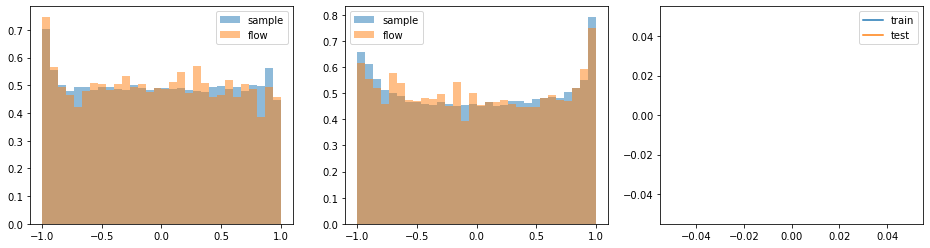

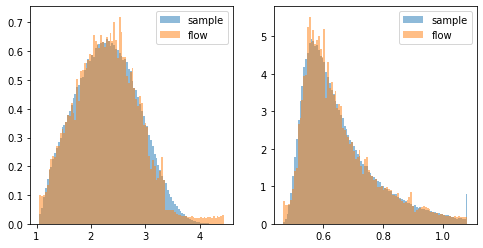

1
[inf, inf]
testing
2
[inf, inf, inf]
testing
3
[inf, inf, inf, inf]
testing
4
[inf, inf, inf, inf, inf]
testing
5
[inf, inf, inf, inf, inf, inf]
testing
plotting


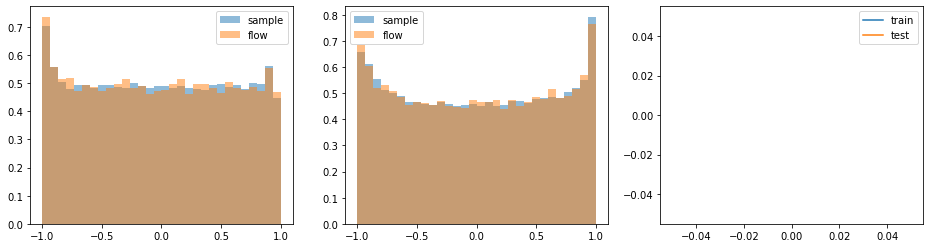

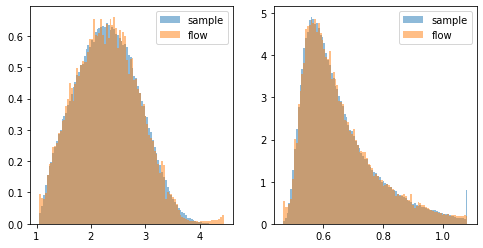

6
[inf, inf, inf, inf, inf, inf, inf]
testing
7
[inf, inf, inf, inf, inf, inf, inf, inf]
testing
8
[inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
9
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
10
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
plotting


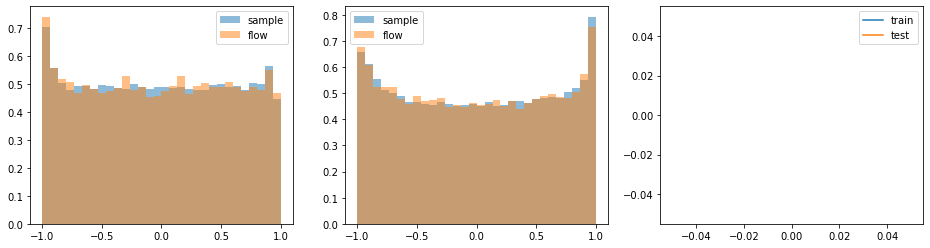

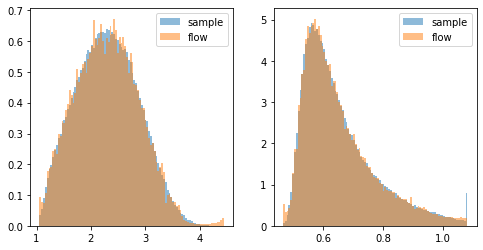

11
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
12
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
13
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
14
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
15
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
plotting


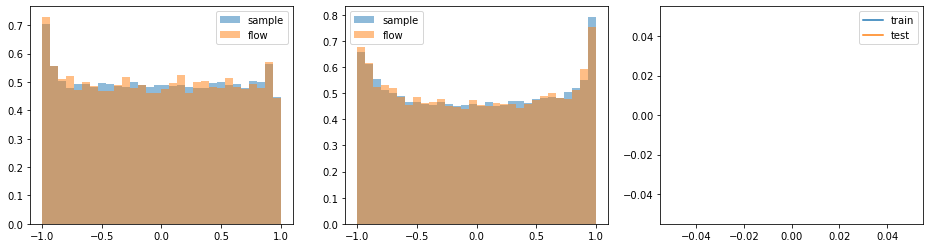

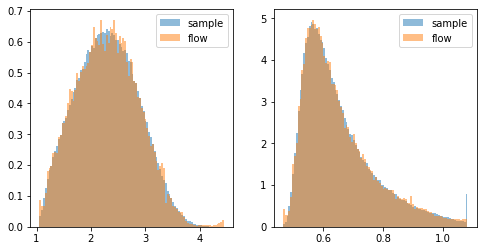

16
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
17
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
18
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
19
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
20
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
plotting


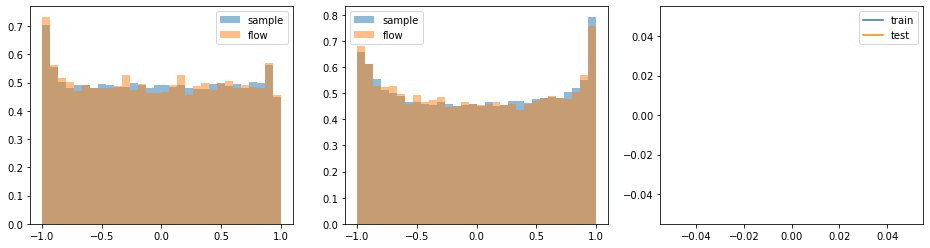

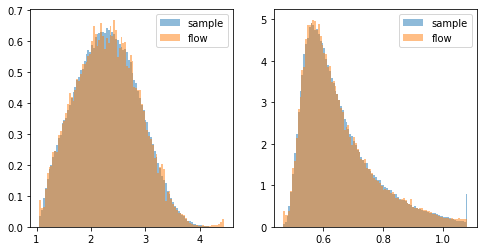

21
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
22
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
23
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
24
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
25
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
plotting


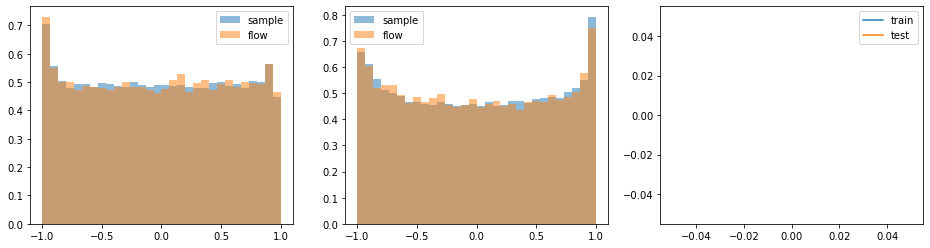

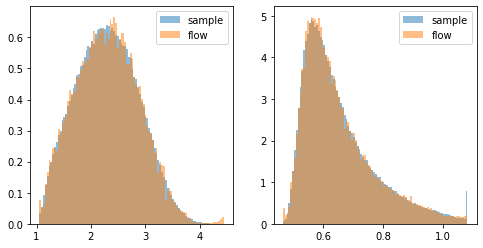

26
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
27
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
28
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
29
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
30
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
plotting


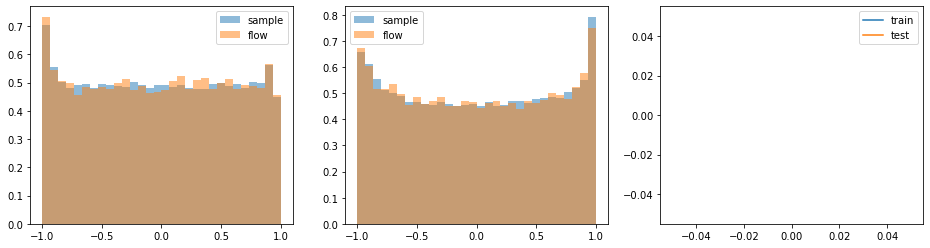

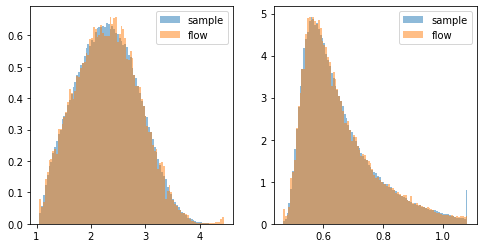

31
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
32
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
33
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
34
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
35
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
plotting


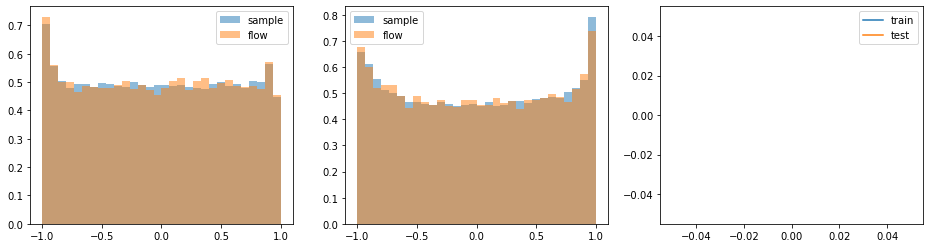

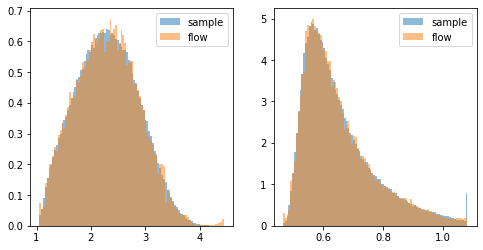

36
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
37
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
38
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
39
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
40
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

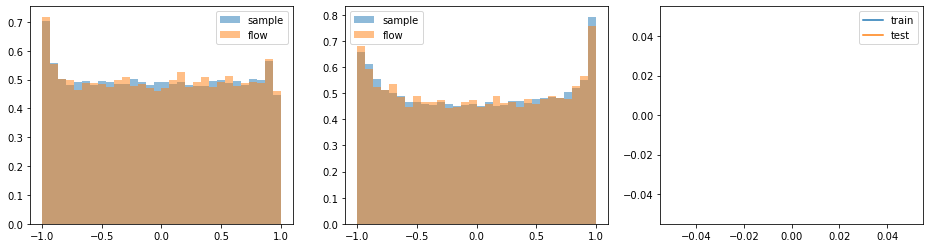

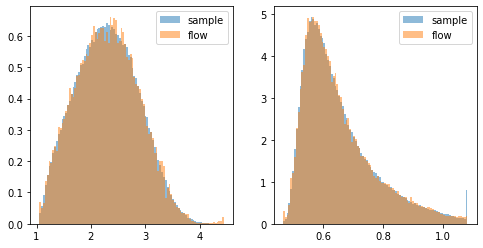

41
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
42
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
43
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
44
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
45
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

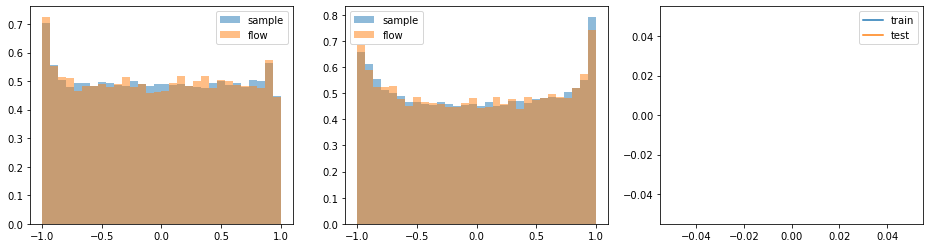

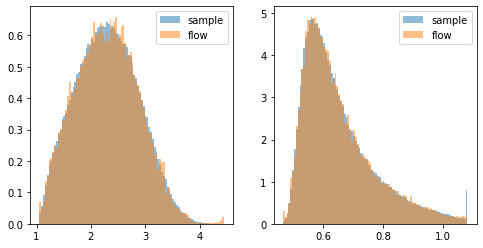

46
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
47
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
48
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
49
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 

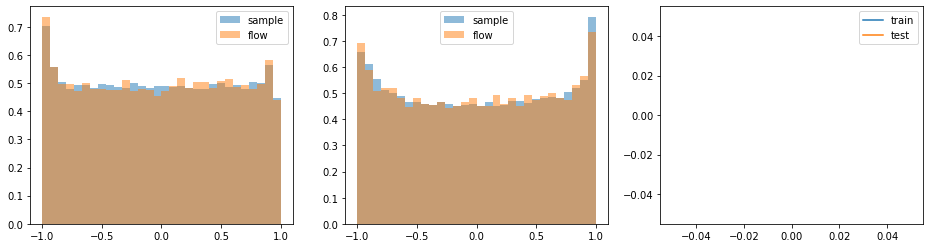

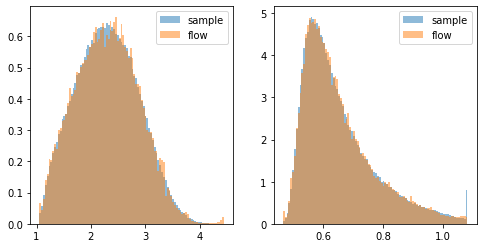

51
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
52
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
53
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
54
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 

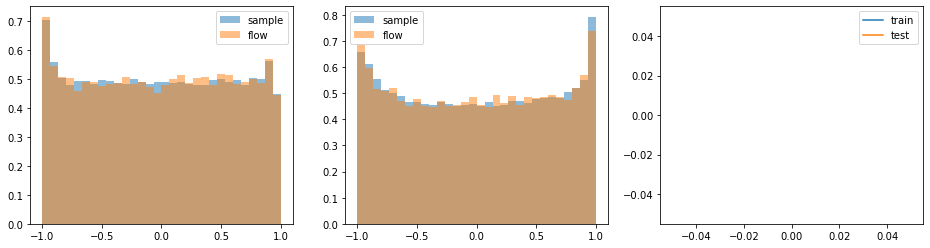

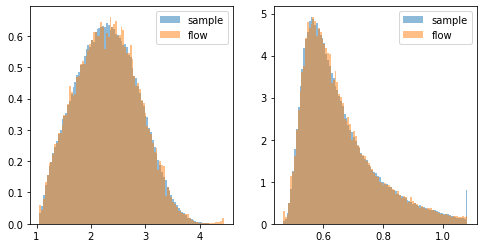

56
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
57
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
58
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
testing
59
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 

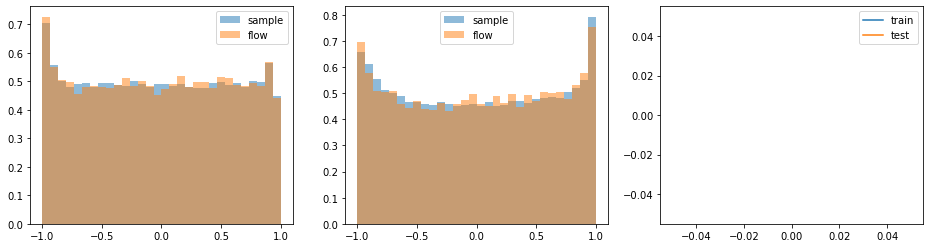

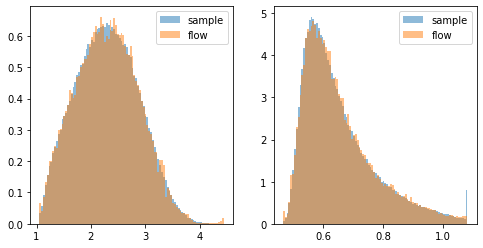

In [15]:
flow_mc = make_base_flow_and_train(mc_loader_train, mc_loader_test, df_test)

0
testing
plotting


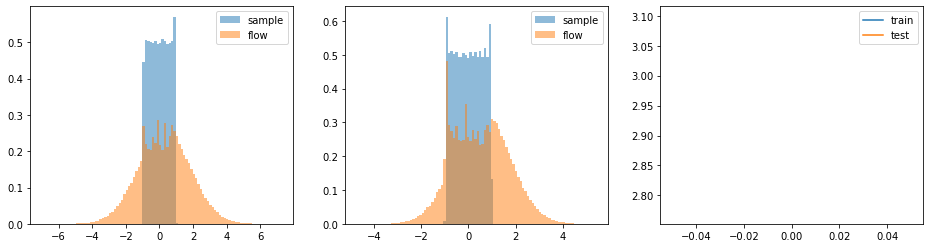

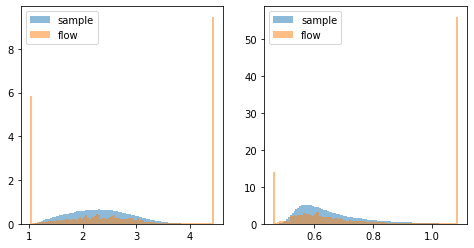

1
testing
2
testing
3
testing
4
testing
5
testing
plotting


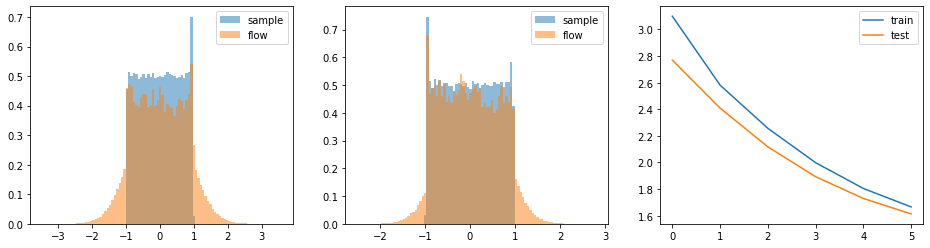

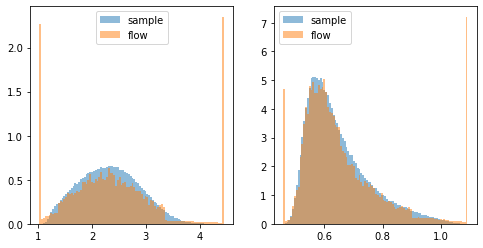

6
testing
7
testing
8
testing
9
testing
10
testing
plotting


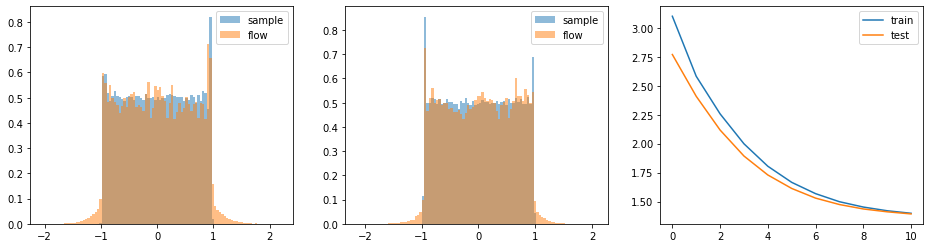

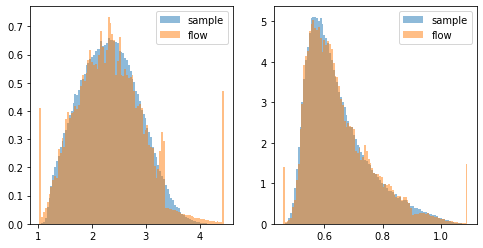

11
testing
12
testing
13
testing
14
testing
15
testing
plotting


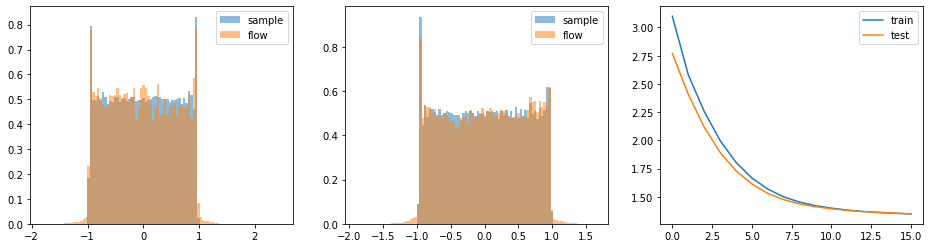

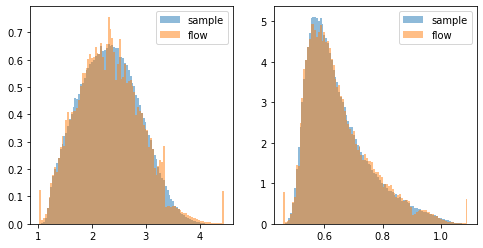

16
testing
17
testing
18
testing
19
testing
20
testing
plotting


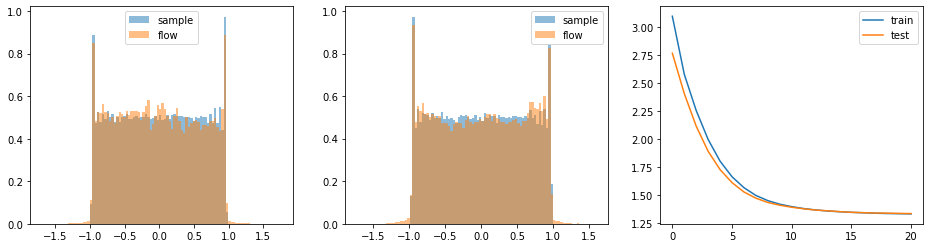

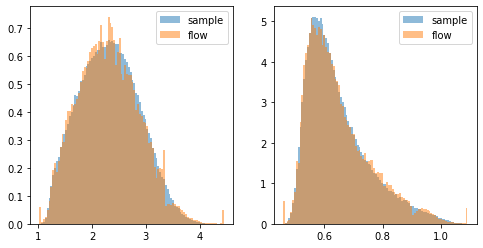

21
testing
22
testing
23
testing
24
testing
25
testing
plotting


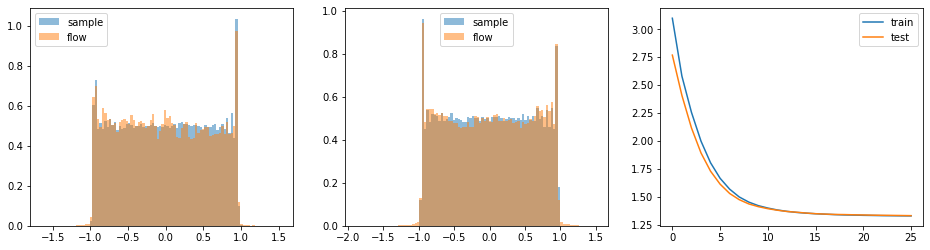

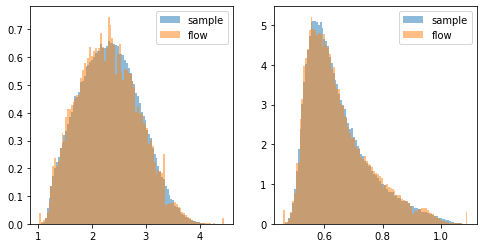

26
testing
27
testing
28
testing
29
testing
30
testing
plotting


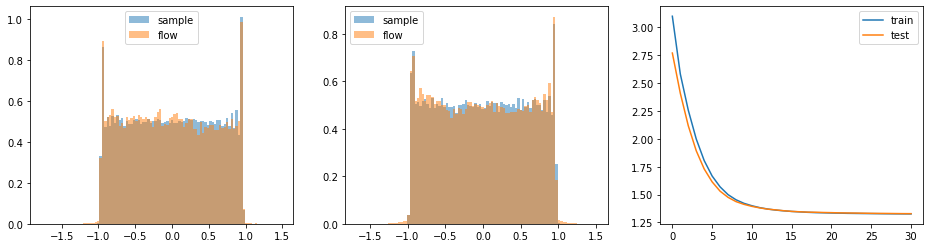

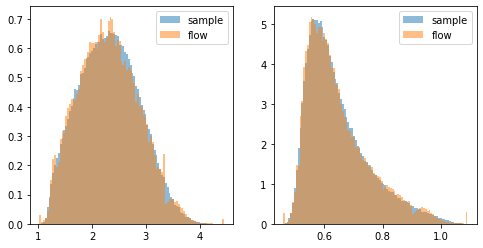

31
testing
32
testing
33
testing
34
testing
35
testing
plotting


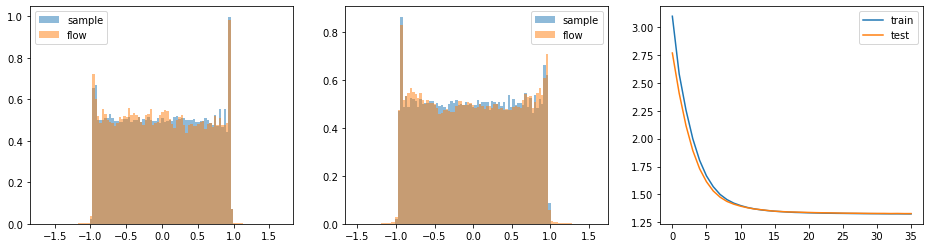

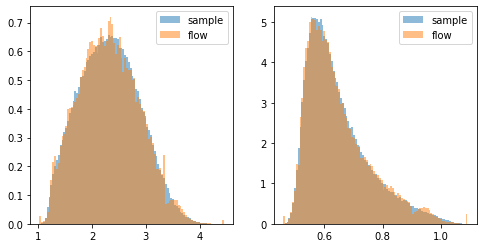

36
testing
37
testing
38
testing
39
testing
40
testing
plotting


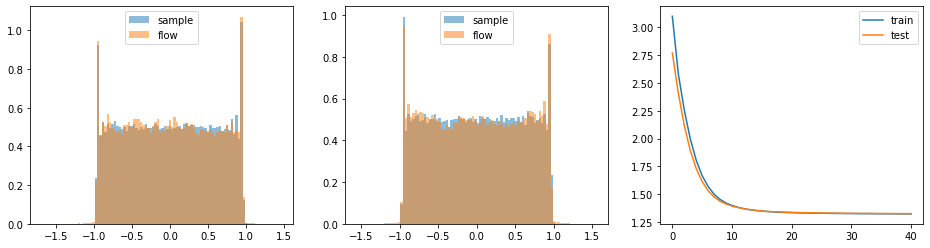

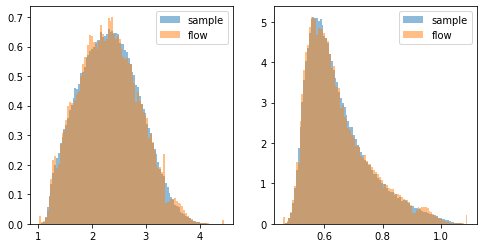

41
testing
42
testing
43
testing
44
testing
45
testing
plotting


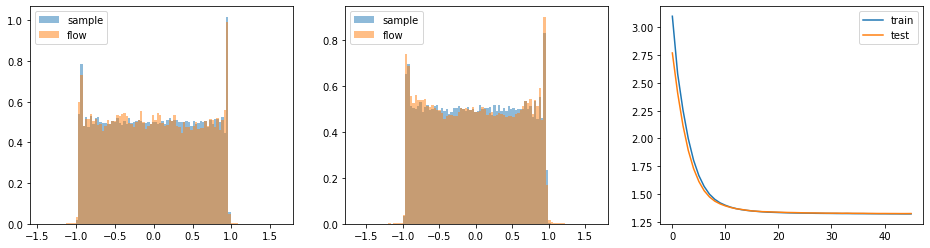

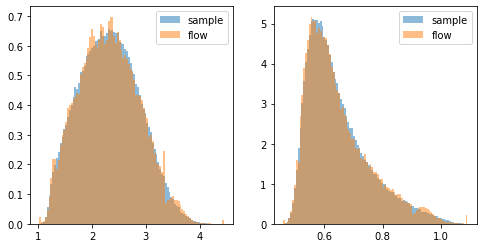

46
testing
47
testing
48
testing
49
testing
50
testing
plotting


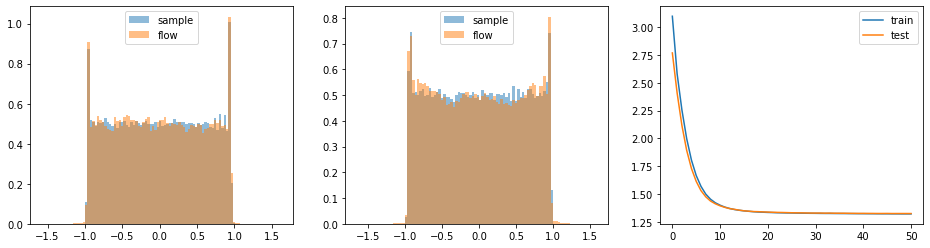

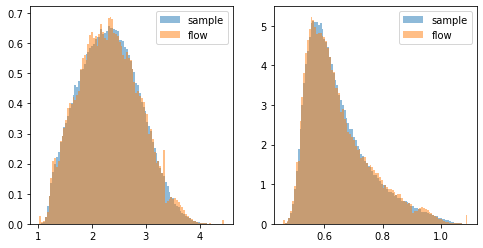

51
testing
52
testing
53
testing
54
testing
55
testing
plotting


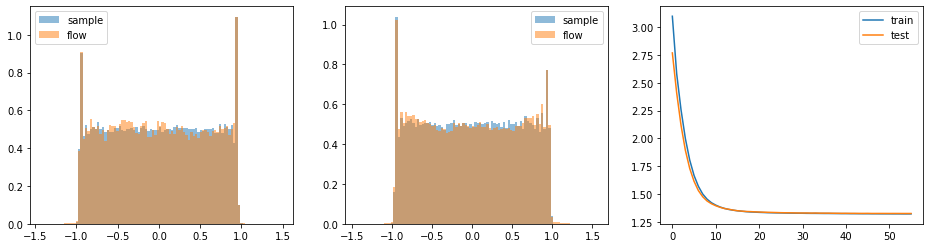

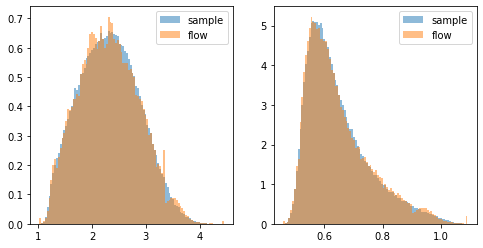

56
testing
57
testing
58
testing
59
testing
60
testing
plotting


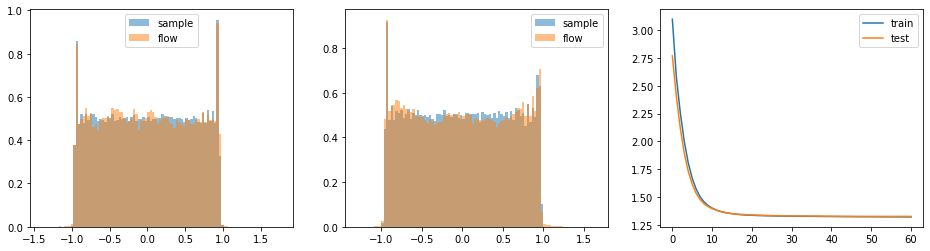

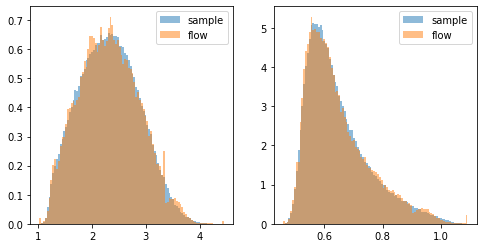

In [13]:
flow_data = make_base_flow_and_train(data_loader_train, data_loader_test, df_target_test)

In [14]:
class BasePenalty(nn.Module):
    def __init__(self, weight=0.0):
        super(BasePenalty, self).__init__()
        self.register_buffer('weight', torch.Tensor([weight]))

    def penalty_function(self, inputs, outputs):
        return 0

    def forward(self, inputs, outputs):
        """Return calculation of distance penalty with gradients"""
        return self.weight * self.penalty_function(inputs, outputs)

class WrapPytorchPenalty(BasePenalty):
    """Wrapper class for distance penalty from any predefined pytorch method for FlowForFlow model"""
    def __init__(self, pytorch_method, weight):
        """Create a distance penalty class from a pytorch method
        Inputs
            pytorch_method: PyTorch function for distance penalty
            weight: relative weight for penalty term in total loss"""
        super(WrapPytorchPenalty, self).__init__(weight)
        self.torch_penalty = pytorch_method(reduction='none')

    def penalty_function(self, inputs, outputs):
        return self.torch_penalty(outputs, inputs).sum(-1)

class LOnePenalty(WrapPytorchPenalty):
    """L1 distance penalty clas for FlowForFlow models"""
    def __init__(self, weight):
        """Create a L1 distance penalty term
        Inputs
            weight: relative weight for penalty term in total loss"""
        super(LOnePenalty, self).__init__(nn.L1Loss, weight)
        
class AnnealedPenalty(BasePenalty):
    """Annealing weight for distance penalty class"""
    def __init__(self, penalty, n_steps=None, min_weight=0):
        """Create an annealing distance penalty term
        Inputs
            penalty: Distance penalty class
            n_steps: How many steps in the training of the flow
            min_weight minimum value for weight of distance penalty class"""
        super(AnnealedPenalty, self).__init__()
        self.min_weight = min_weight
        self.penalty_to_wrap = penalty
        self.initial_weight = deepcopy(self.penalty_to_wrap.weight)
        self.n_steps = n_steps
        self.pi = torch.tensor(np.pi, dtype=torch.float32)
        self.step = 0

    def set_n_steps(self, n_steps):
        if self.n_steps is None:
            self.n_steps = n_steps

    def update_weight(self):
        # TODO currently following a cosine schedule, but this should be possible to set/configure.
        self.penalty_to_wrap.weight = self.min_weight + 0.5 * (self.initial_weight - self.min_weight) * (
                    1 + (self.pi * self.step / self.n_steps).cos())
        self.step += 1

    def penalty_function(self, inputs, outputs):
        self.update_weight()
        return self.penalty_to_wrap.penalty_function(inputs, outputs)    

def set_penalty(f4flow, penalty, weight, anneal=False):
    if penalty not in ["None", None]:
        if penalty == "l1":
            penalty_constr = LOnePenalty
        penalty = penalty_constr(weight)
        if anneal:
            penalty = AnnealedPenalty(penalty)
        f4flow.add_penalty(penalty)

class FFFCustom(flows.Flow):
    def __init__(self, transform, flow_mc, flow_data, embedding_net=None):
        super().__init__(transform, flow_mc, embedding_net)
        self.flow_mc = flow_mc
        self.flow_data = flow_data

    def add_penalty(self, penalty_object):
        """Add a distance penaly object to the class."""
        assert isinstance(penalty_object, BasePenalty)
        self.distance_object = penalty_object

    def base_flow_log_prob(
        self, inputs, context, inverse=False
    ):
        if inverse:
            fnc = self.flow_mc.log_prob
        else:
            fnc = self.flow_data.log_prob
        logprob = fnc(inputs, context)
        return logprob

    def transform(self, inputs, context, inverse=False):
        context = self._embedding_net(context)
        transform = self._transform.inverse if inverse else self._transform
        y, logabsdet = transform(inputs, context)

        return y, logabsdet

    def log_prob(self, inputs, context, inverse=False):
        converted_input, logabsdet = self.transform(
            inputs, context, inverse=inverse
        )
        log_prob = self.base_flow_log_prob(
            converted_input, context, inverse=inverse
        )
        dist_pen = -self.distance_object(converted_input, inputs)

        return log_prob, logabsdet, dist_pen

In [15]:
# freeze base flows
for param in flow_data.parameters():
    param.requires_grad = False

for param in flow_mc.parameters():
    param.requires_grad = False

fffmodel = FFFCustom(
    spline_inn(
        ninput,
        nodes=2,
        num_blocks=2,
        num_stack=4,
        tail_bound=1.0,
        activation=F.relu,
        dropout_probability=0.1,
        num_bins=16,
        context_features=ncontext,
        flow_for_flow=True,
    ),
    flow_mc,
    flow_data
)
set_penalty(
    fffmodel,
    "l1",
    0.1,
    False
)
fffmodel = fffmodel.to(device)

In [16]:
optimizer = torch.optim.Adam(
    fffmodel.parameters(),
    lr=0.001,
    #betas=(cfg.optimizer.beta1, cfg.optimizer.beta2),
    #weight_decay=cfg.optimizer.weight_decay,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

0


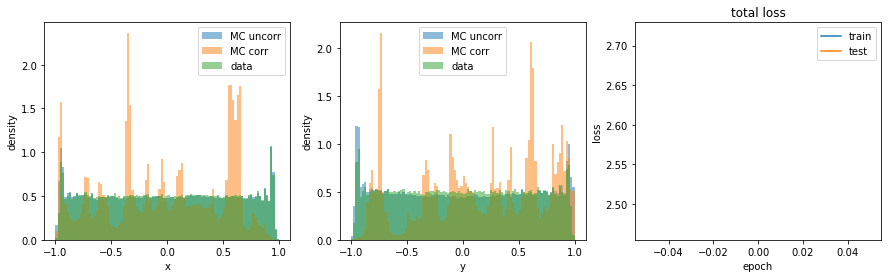

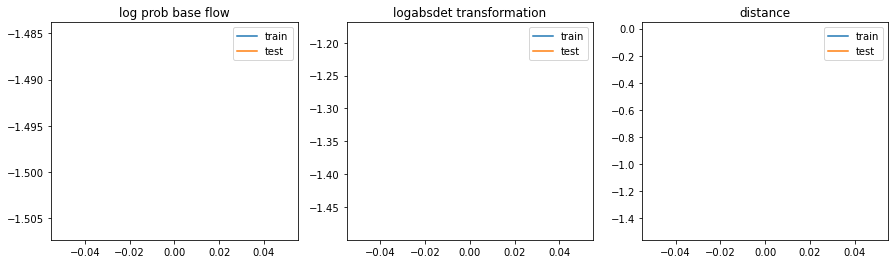

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


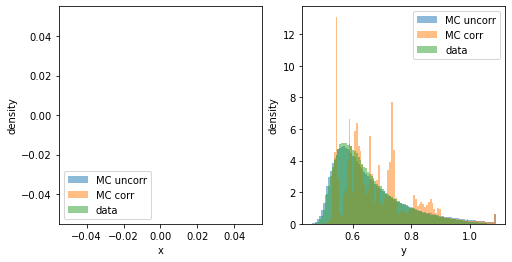

1
2
3
4


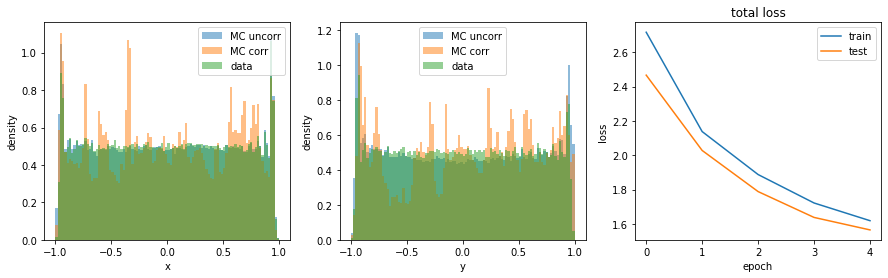

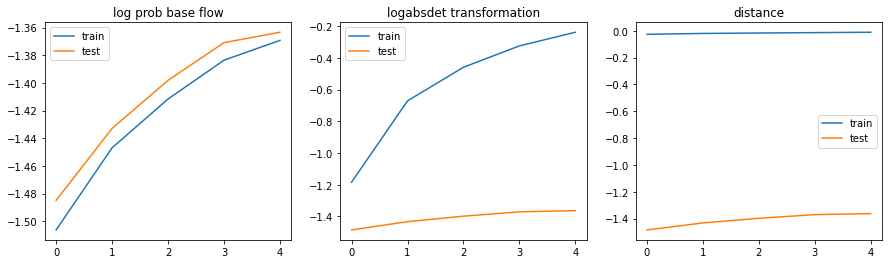

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


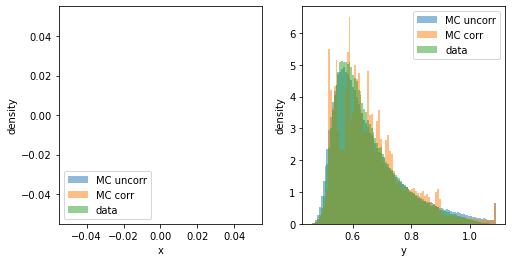

5
6
7
8


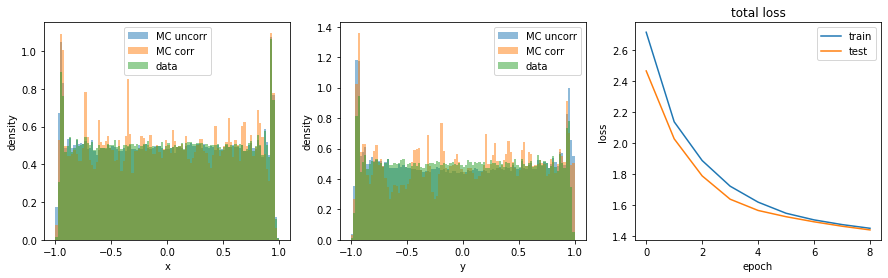

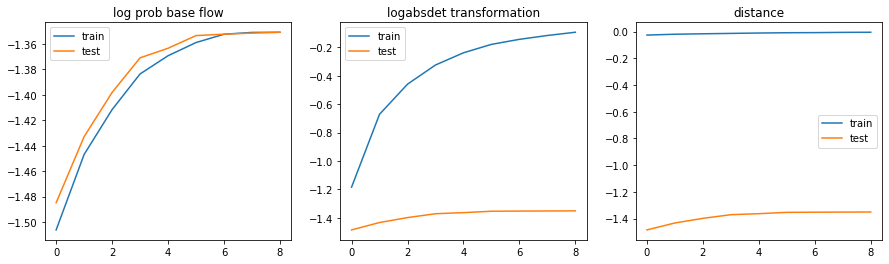

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


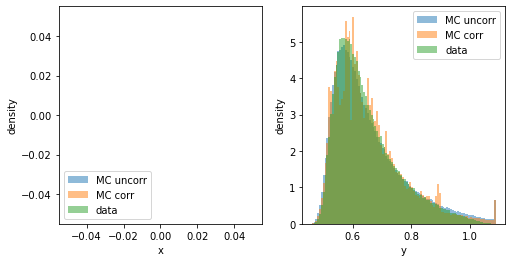

9
10
11
12


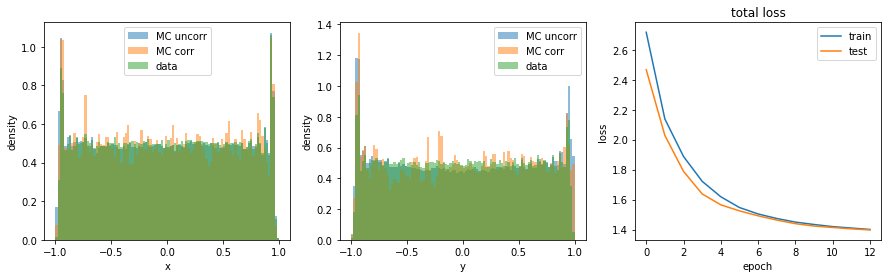

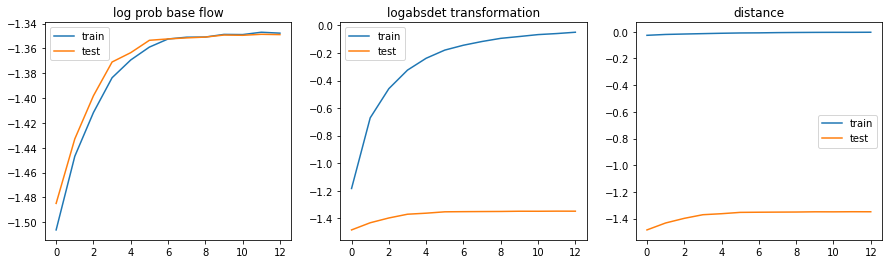

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


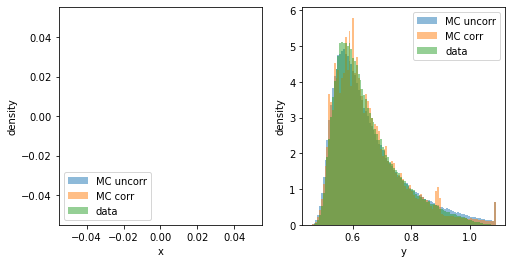

13
14
15
16


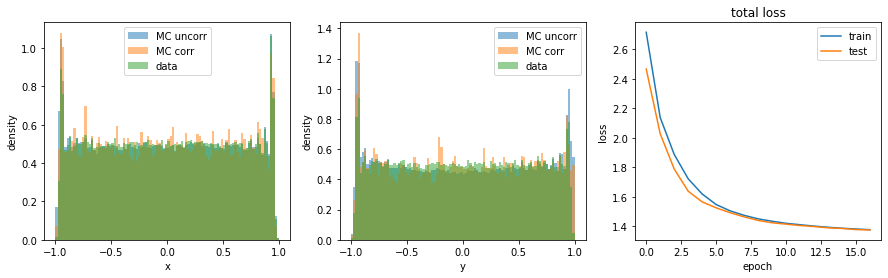

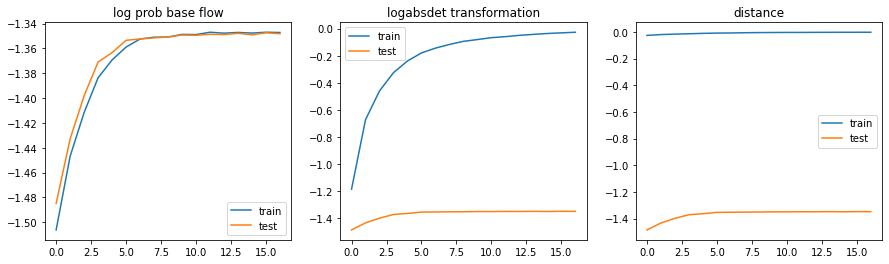

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


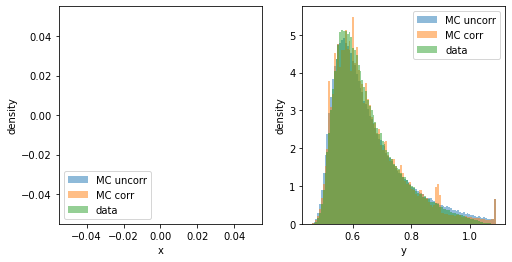

17
18
19
20


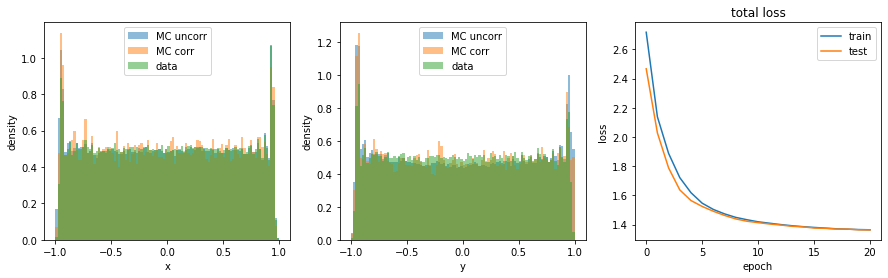

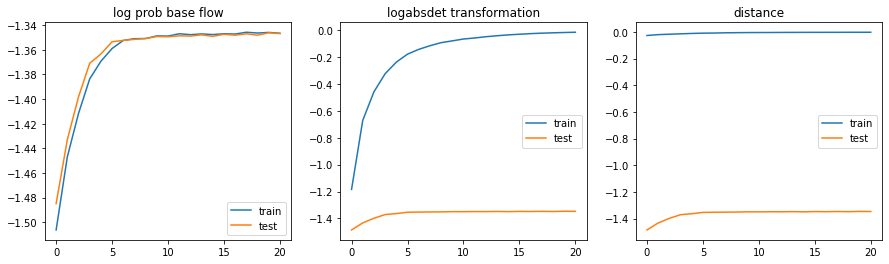

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


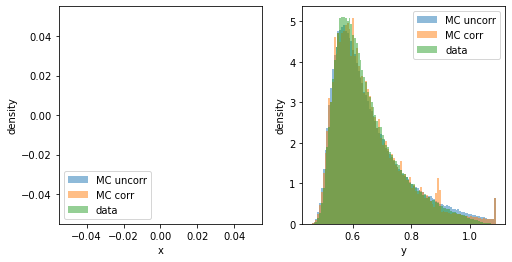

21
22
23
24


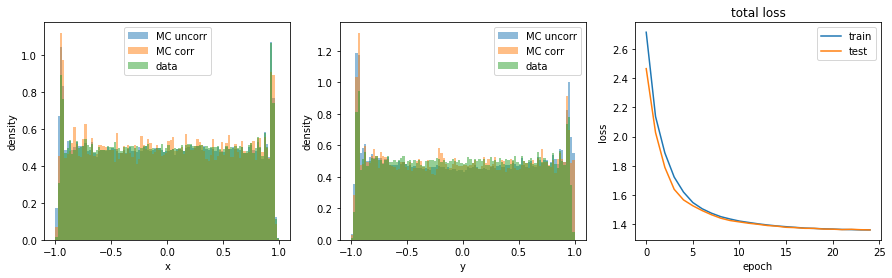

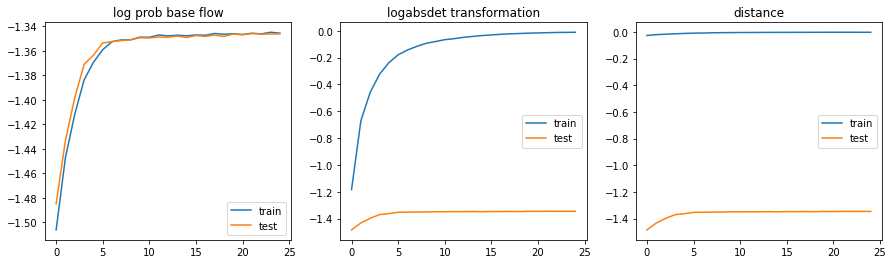

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


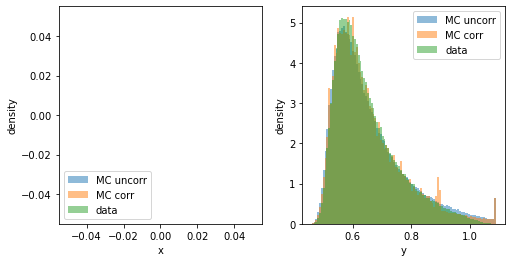

25
26
27
28


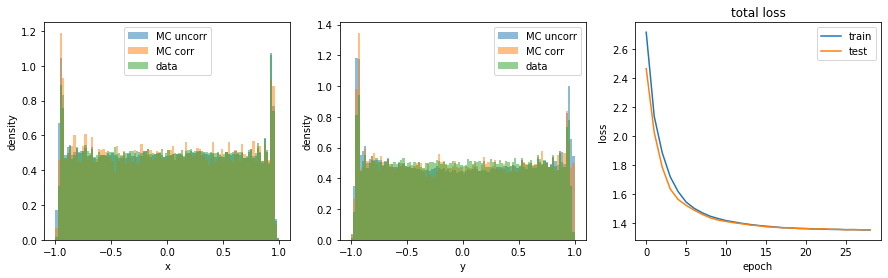

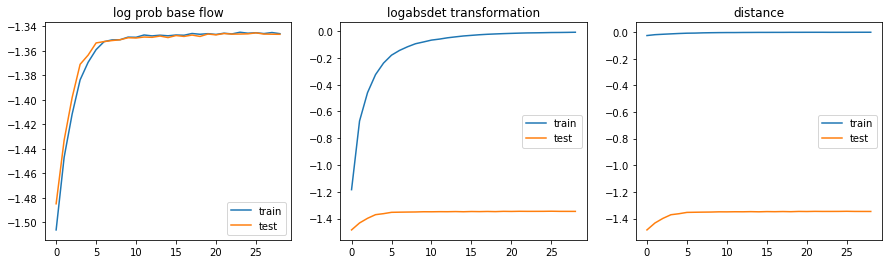

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


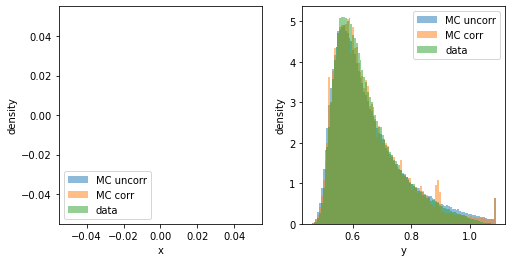

29
30
31
32


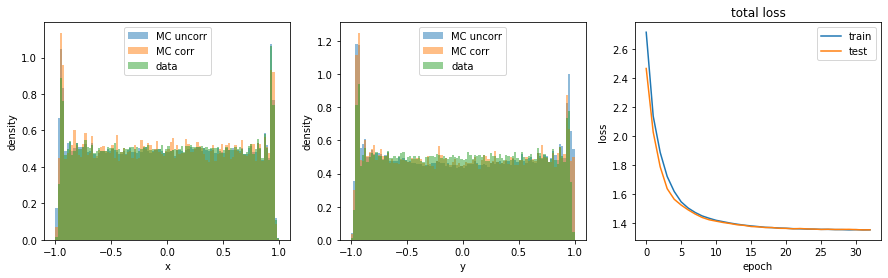

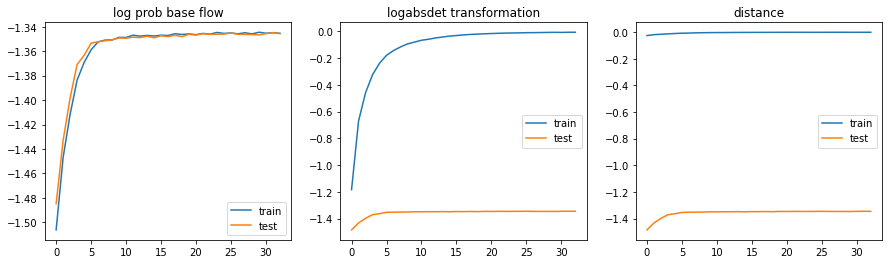

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


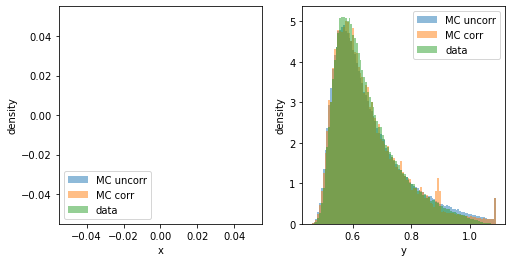

33
34
35
36


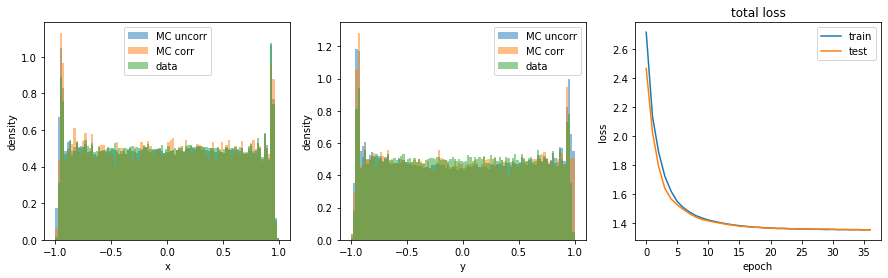

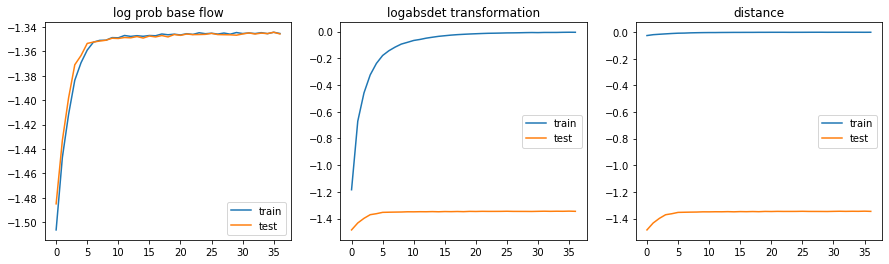

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


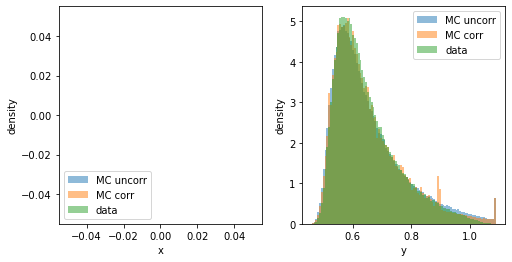

37
38
39
40


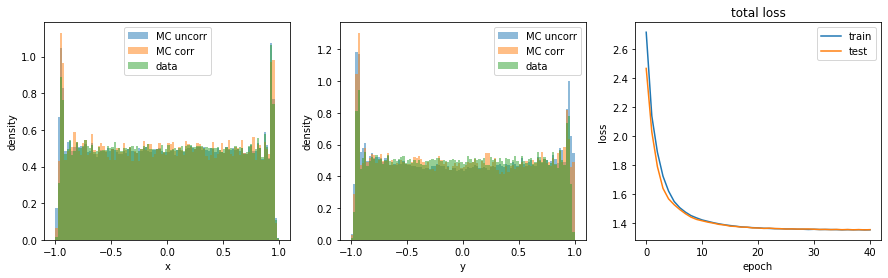

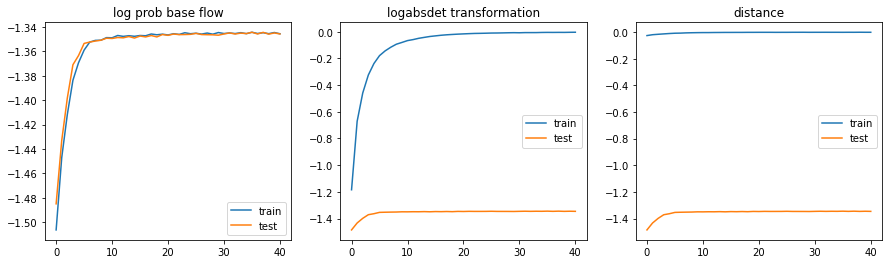

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


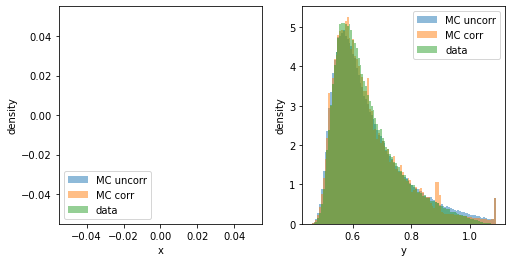

41
42
43
44


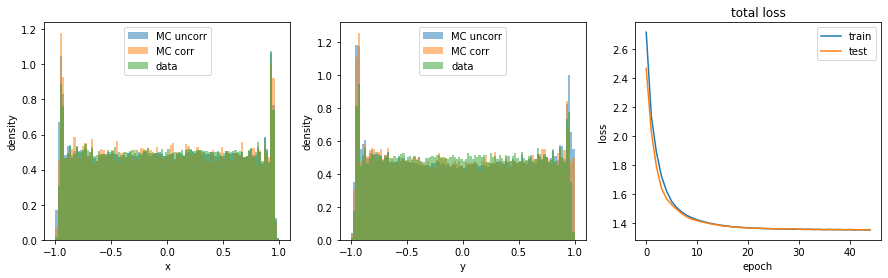

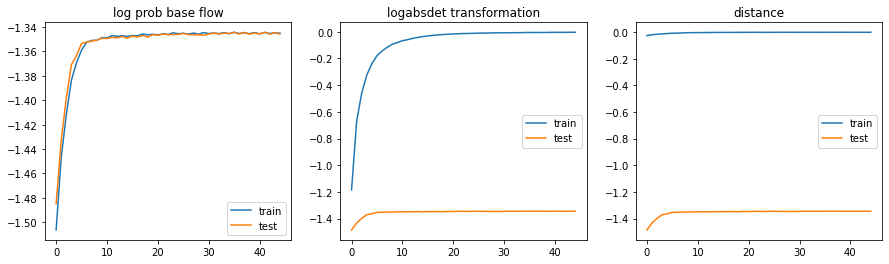

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


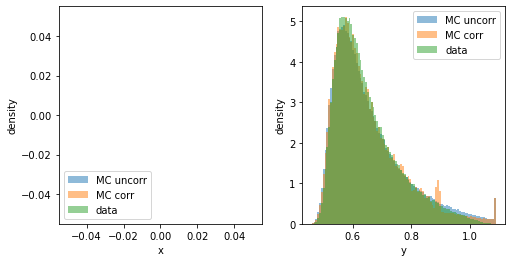

45
46
47
48


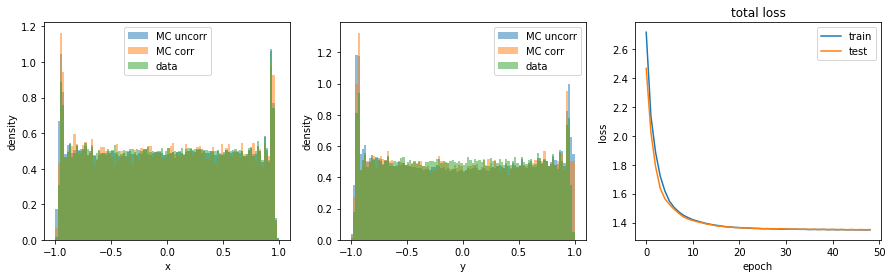

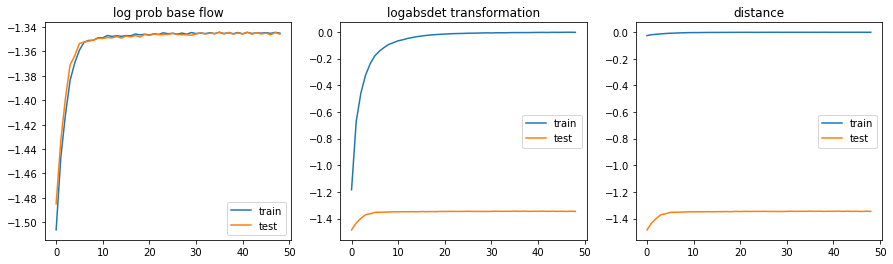

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


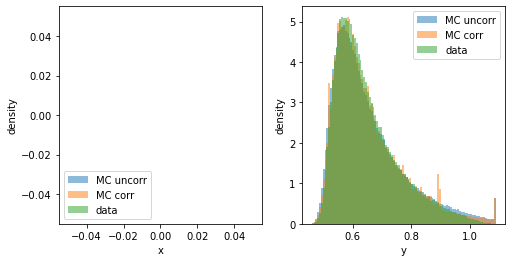

49
50
51
52


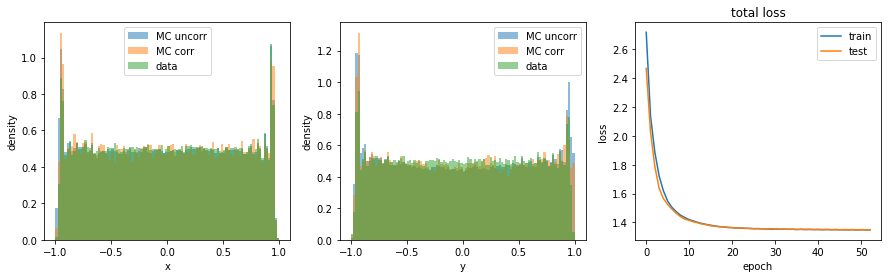

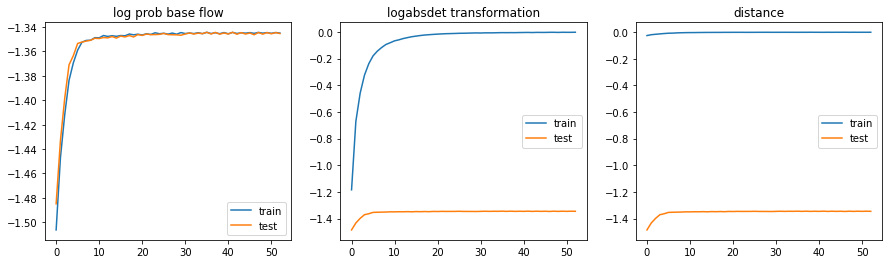

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


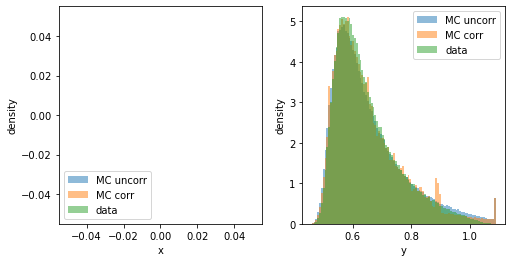

53
54
55
56


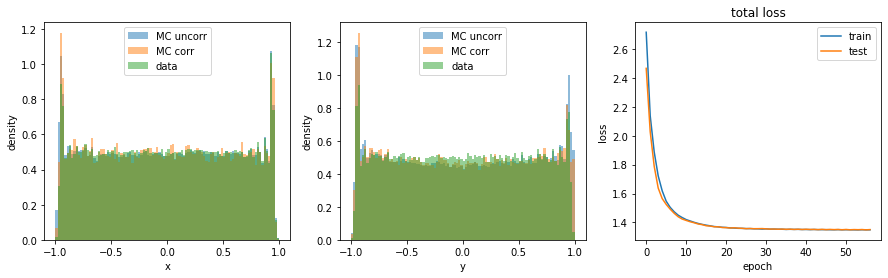

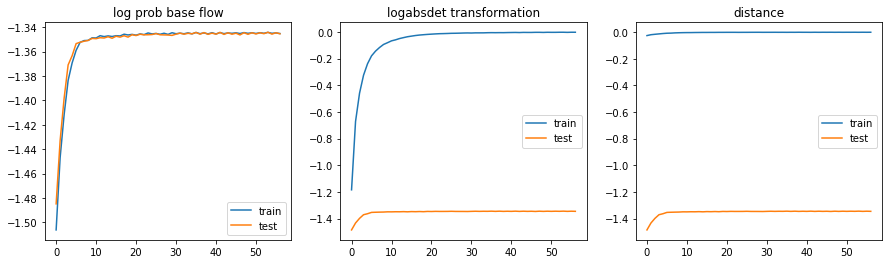

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


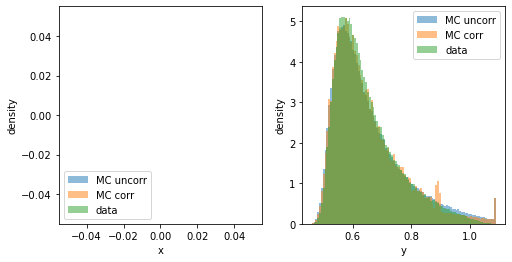

57
58
59
60


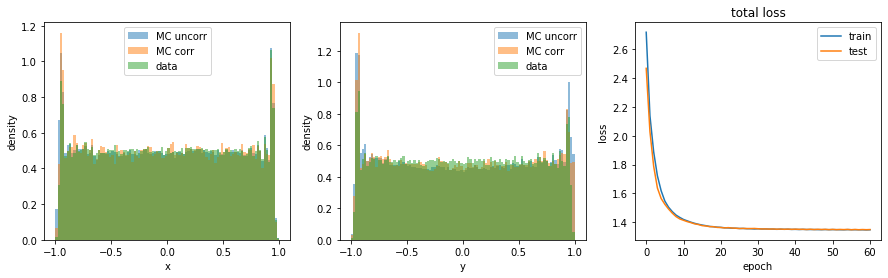

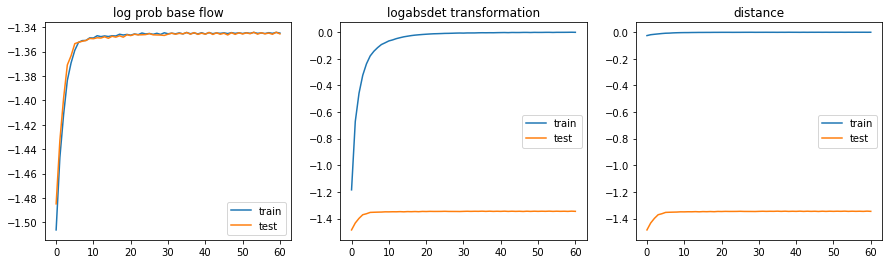

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


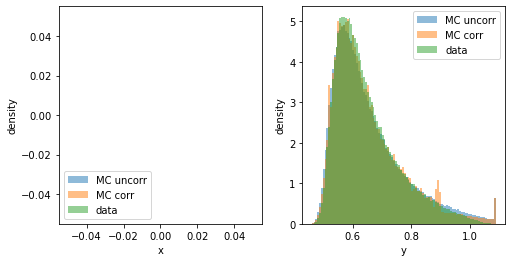

61
62
63
64


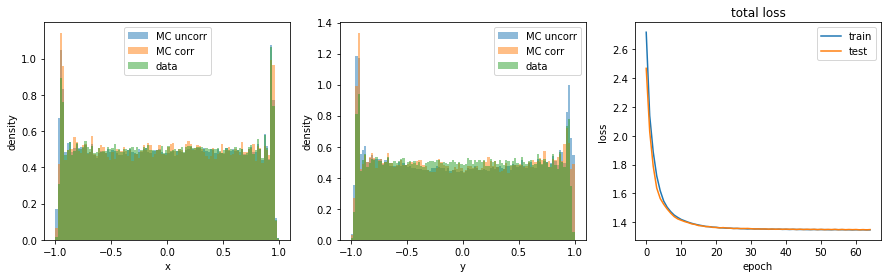

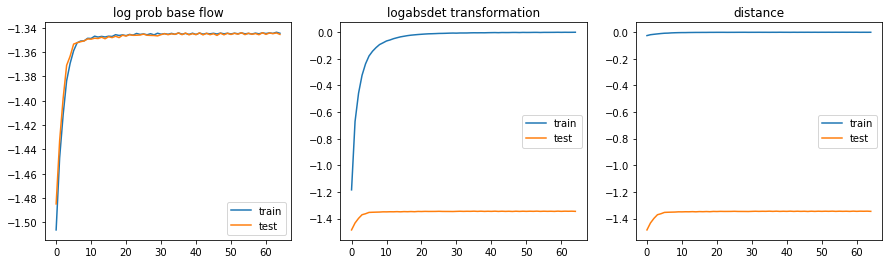

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


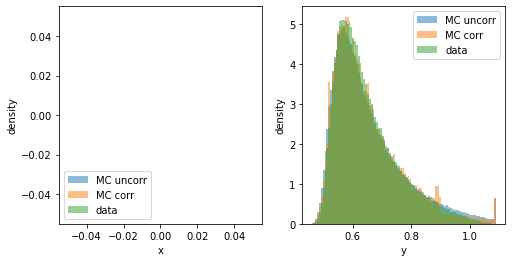

65
66
67
68


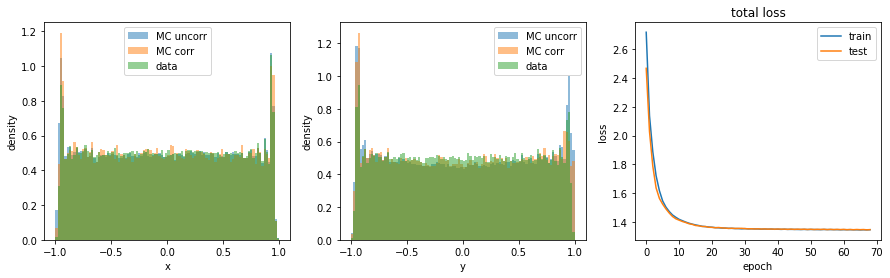

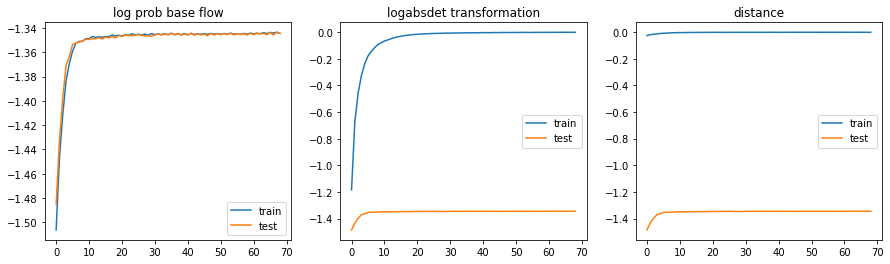

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


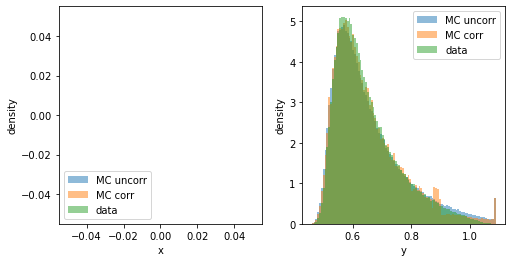

69
70
71
72


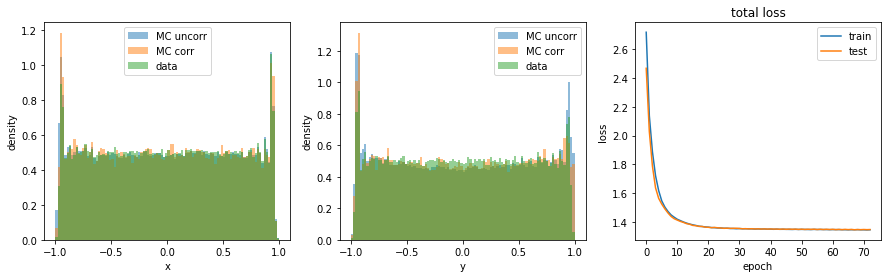

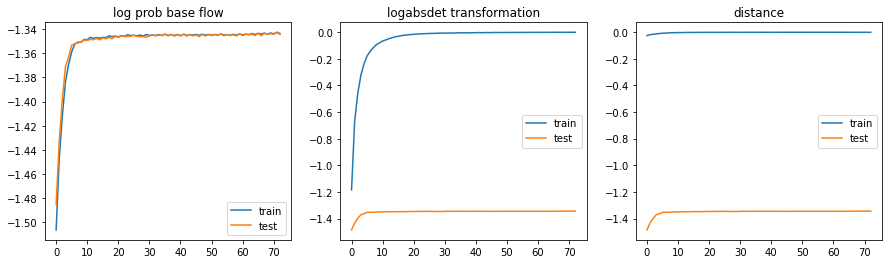

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


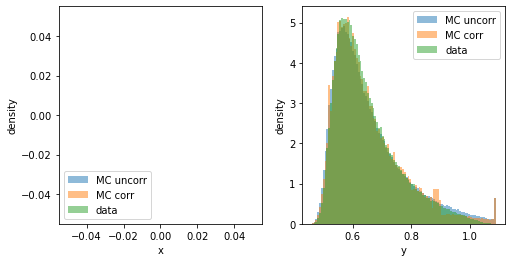

73
74
75
76


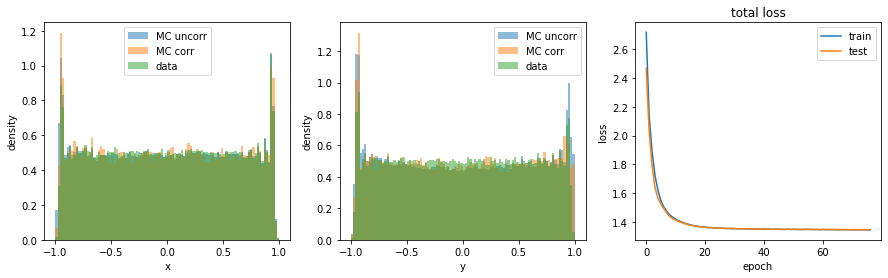

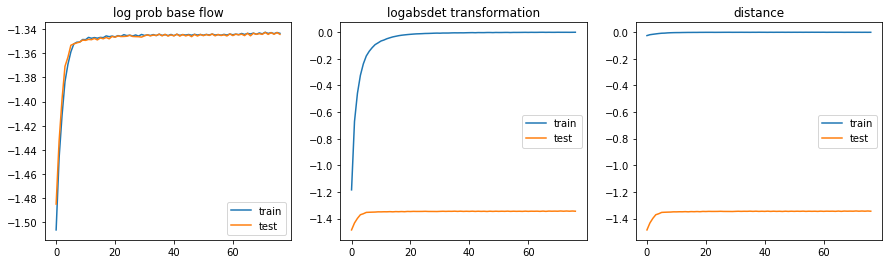

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


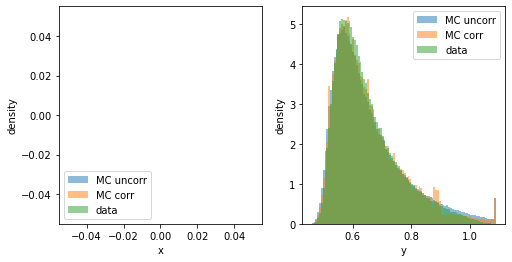

77
78
79
80


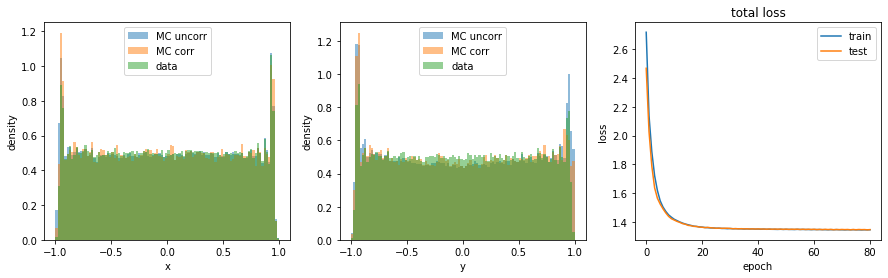

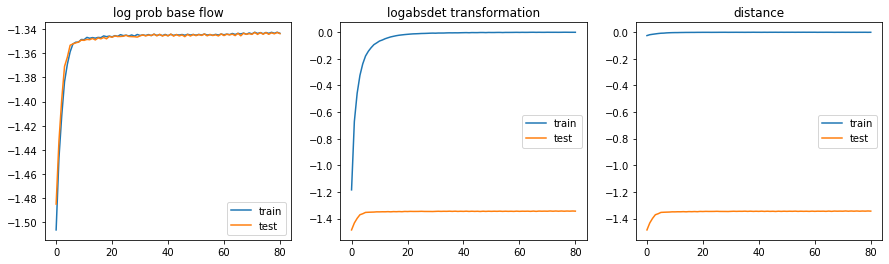

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


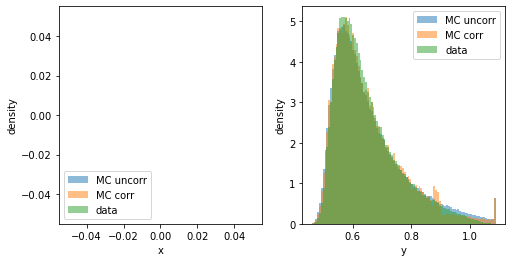

81
82
83
84


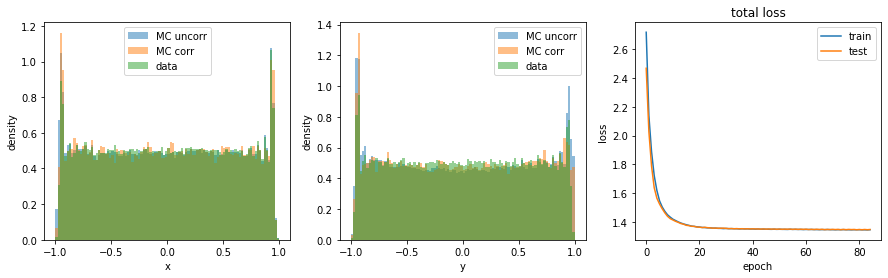

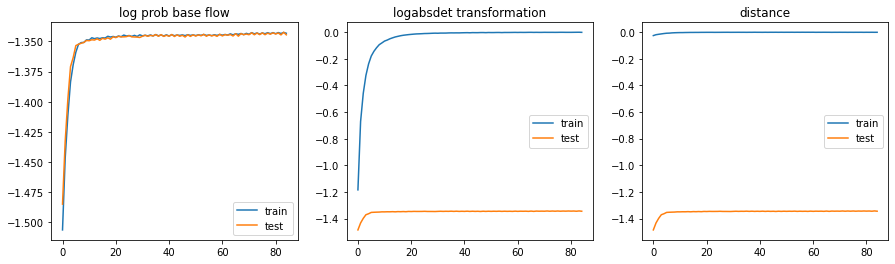

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


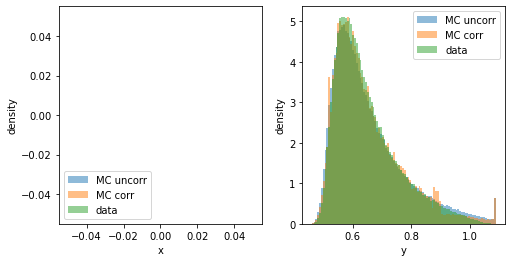

85
86
87
88


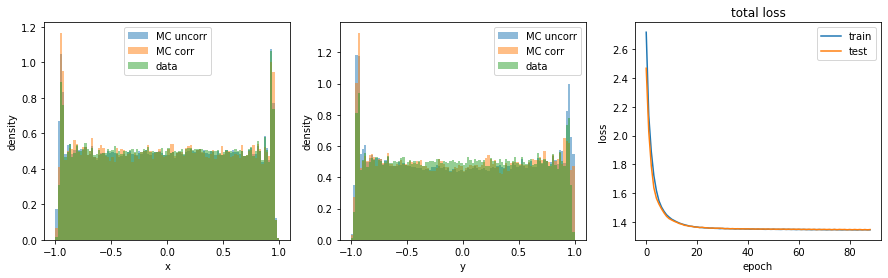

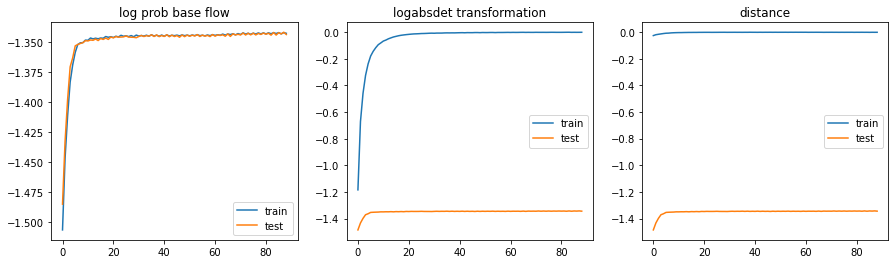

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


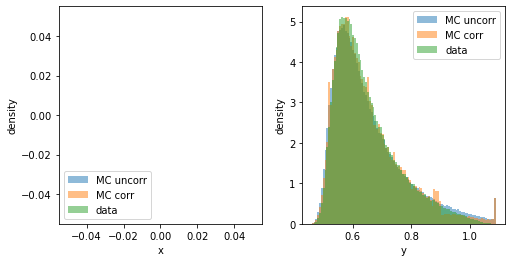

89
90
91
92


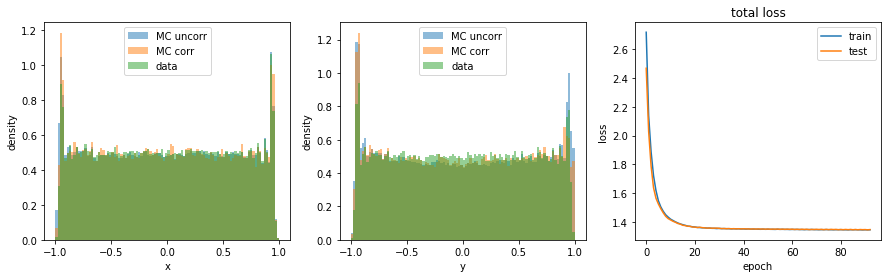

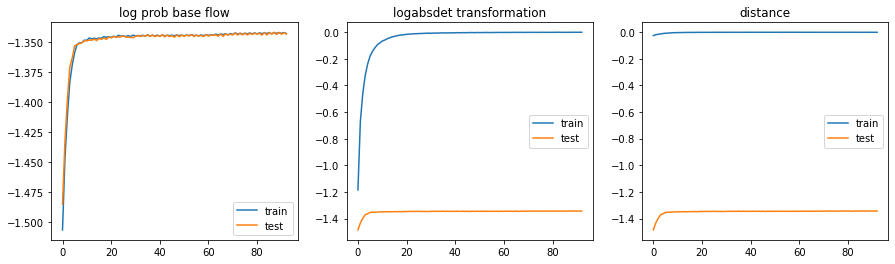

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


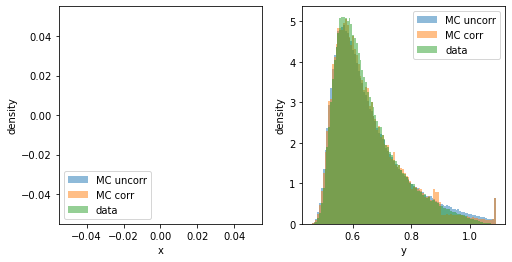

93
94
95
96


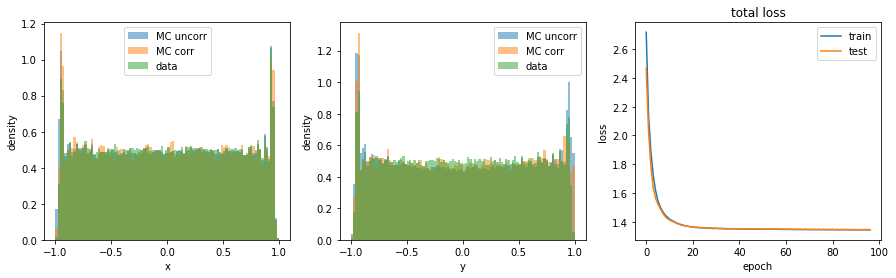

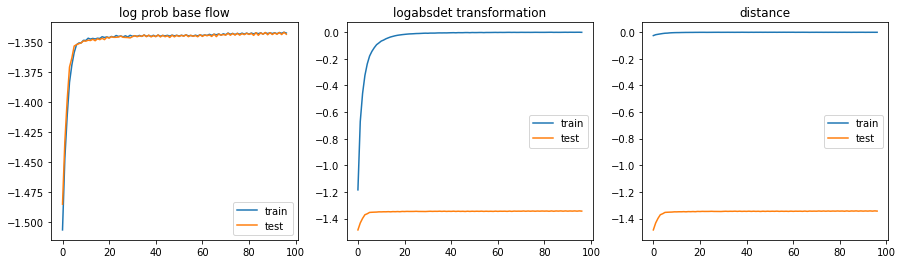

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


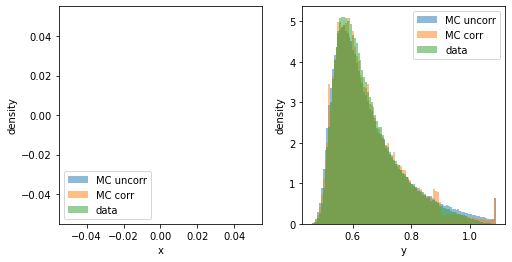

97
98
104


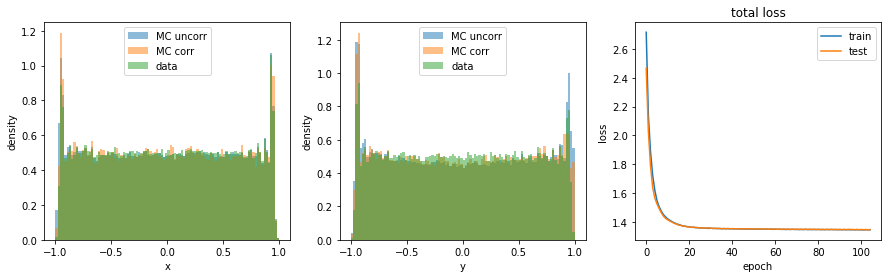

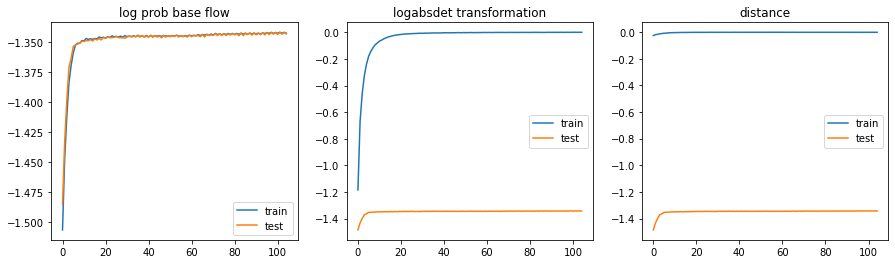

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


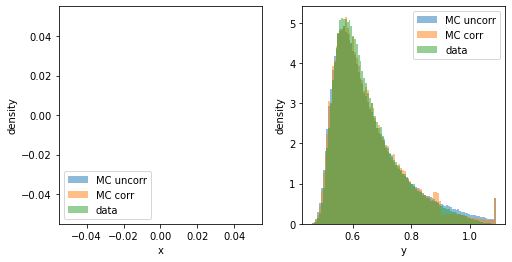

105
106
107
108


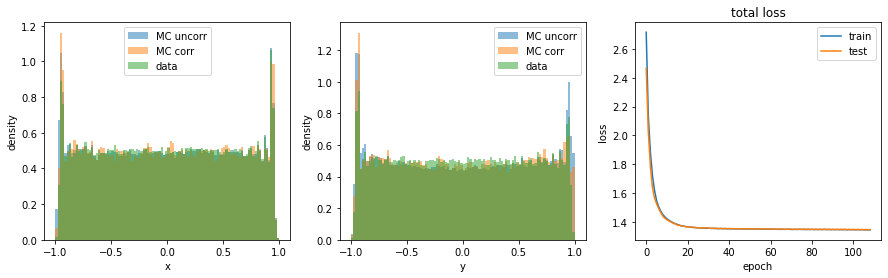

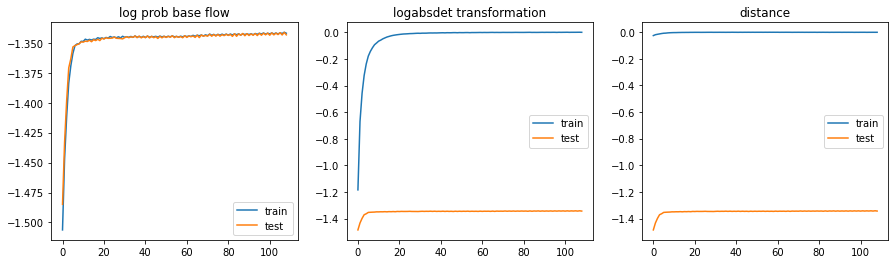

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


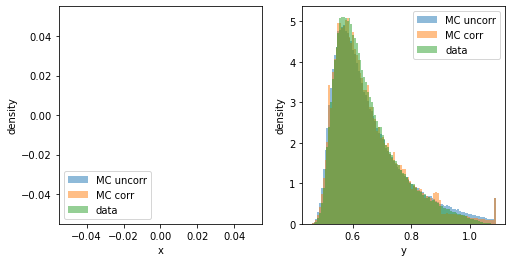

109
110
111
112


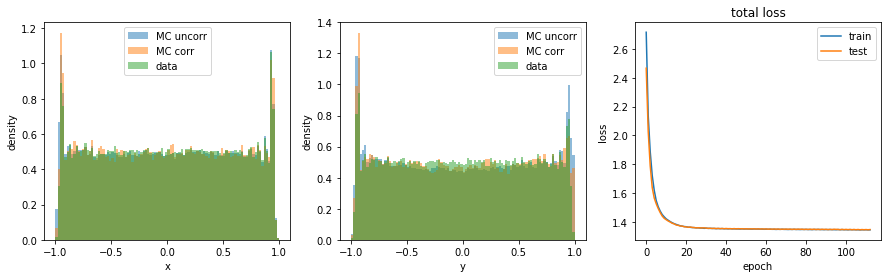

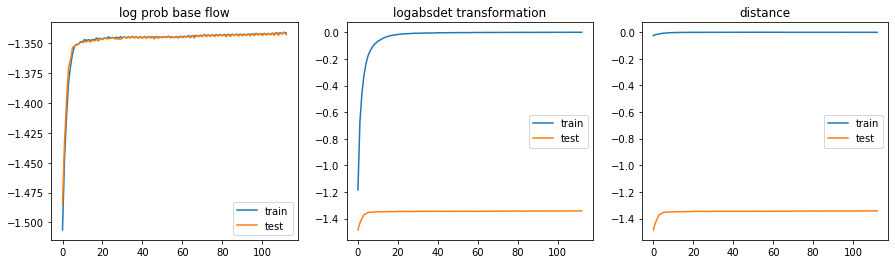

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


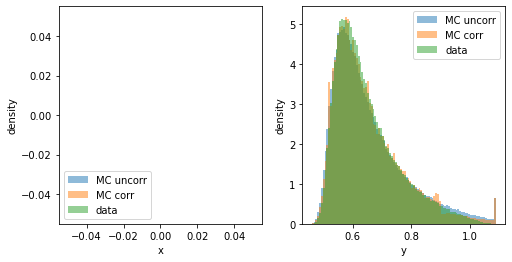

113
114
115
116


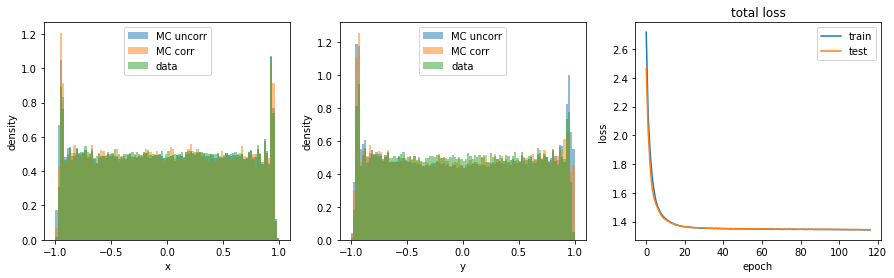

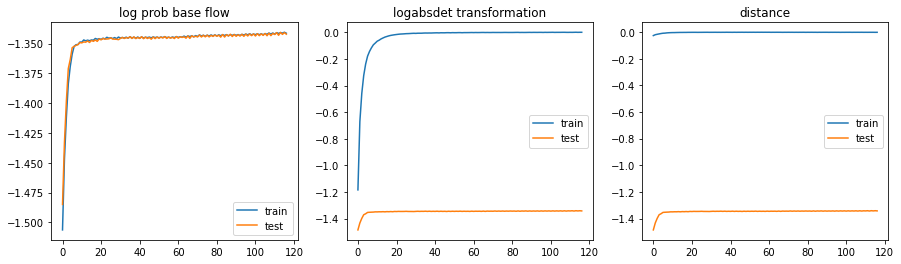

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


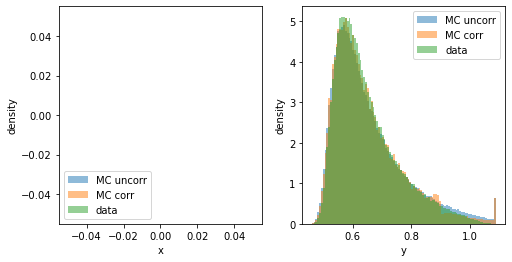

117
118
119
120


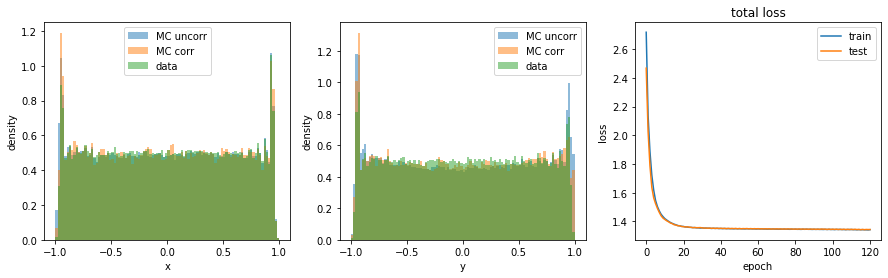

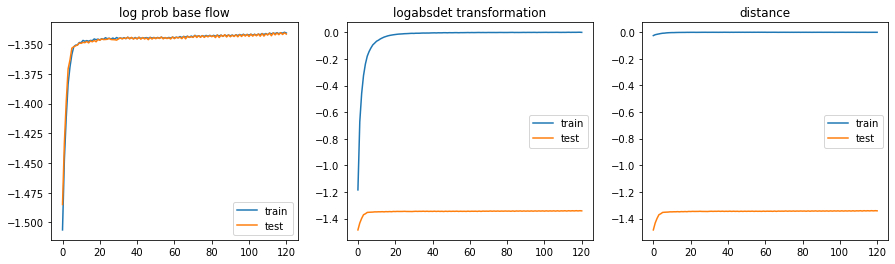

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


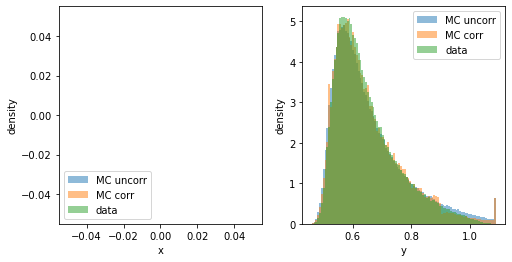

121
122
123
124


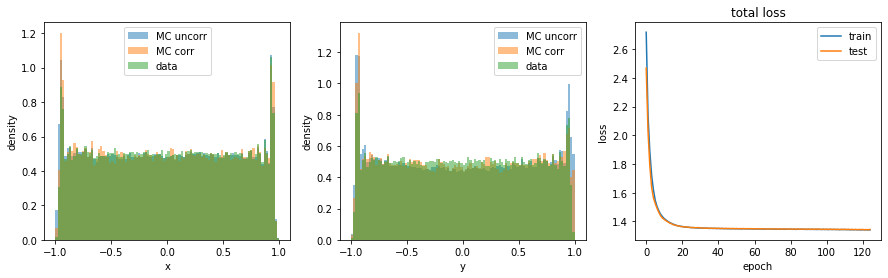

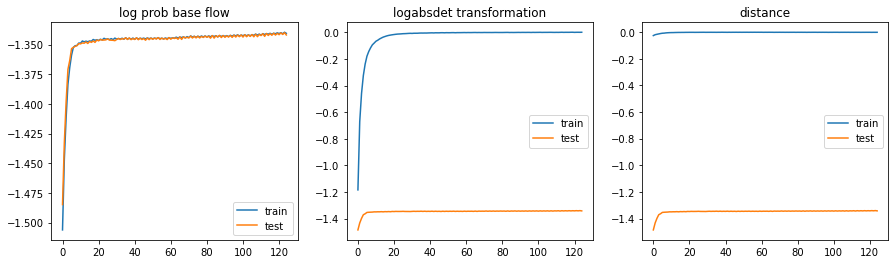

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


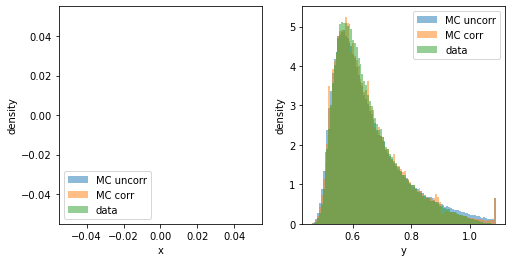

125
131
132


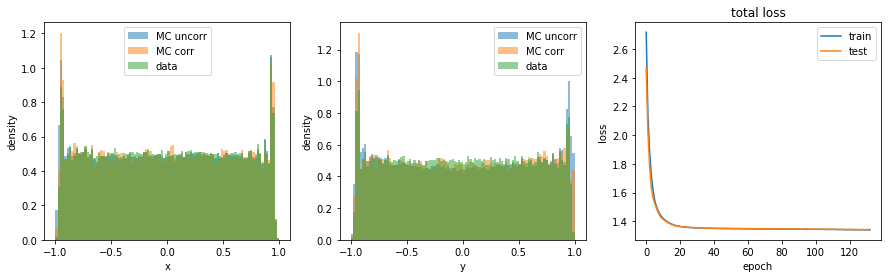

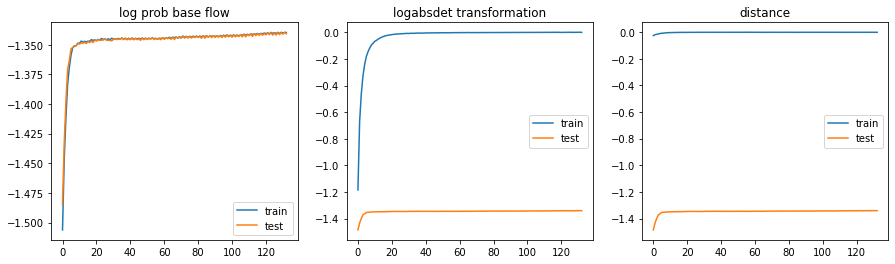

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


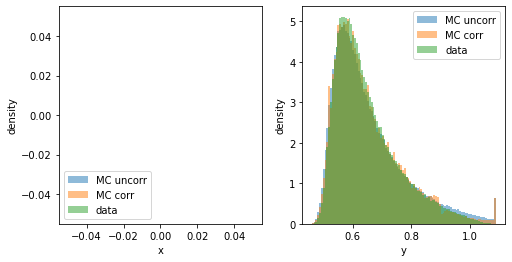

133
134
135
136


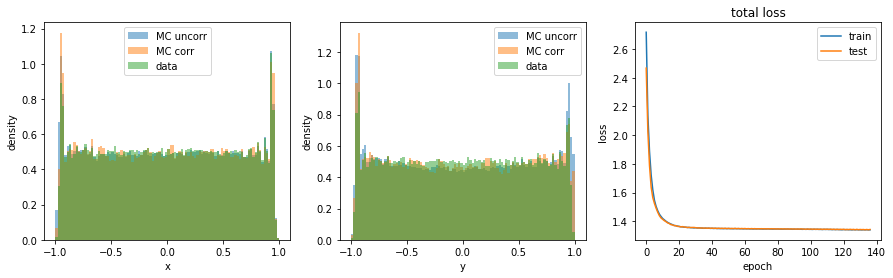

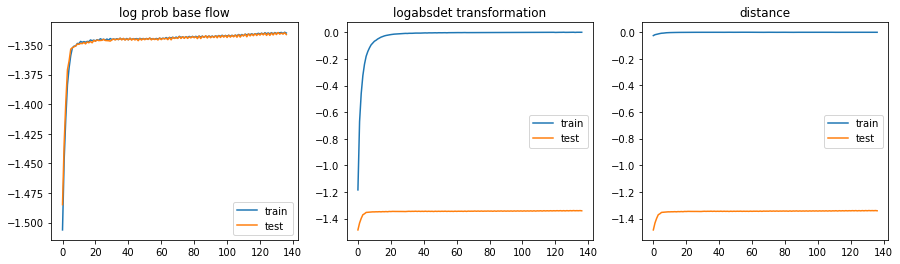

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


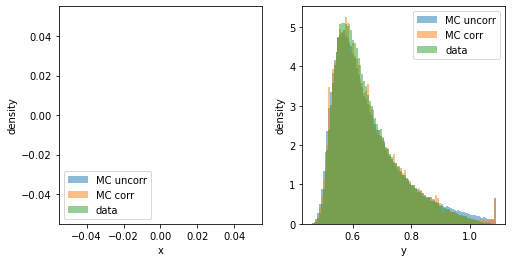

137
138
139
140


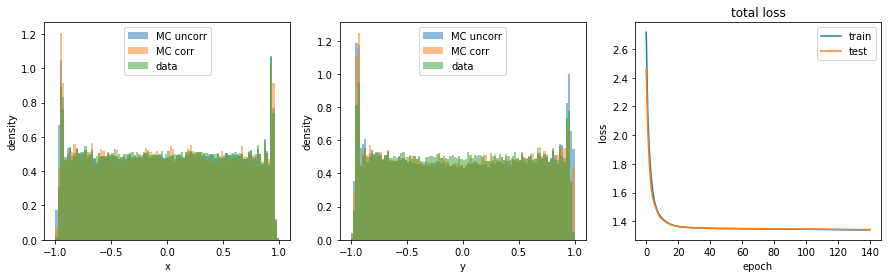

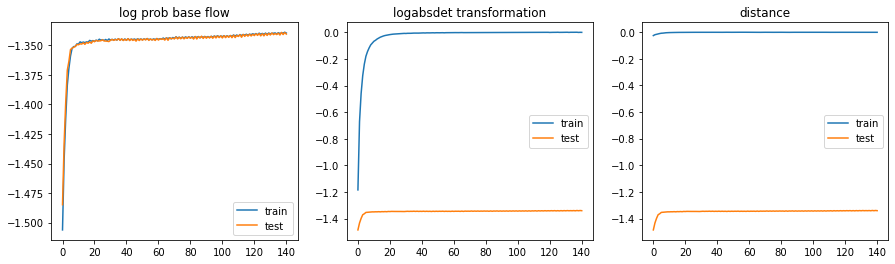

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


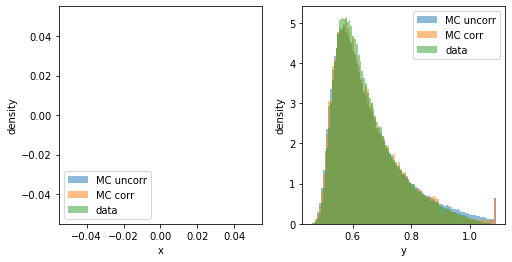

141
142
143
144


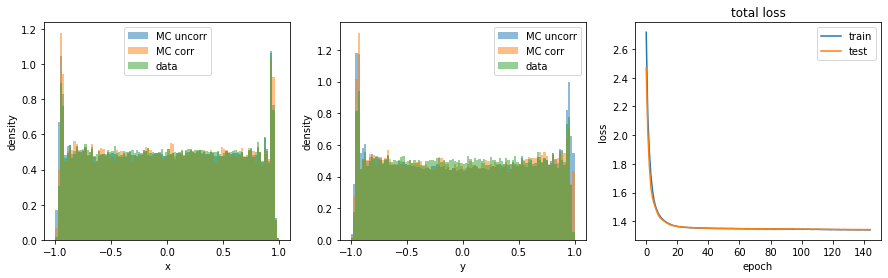

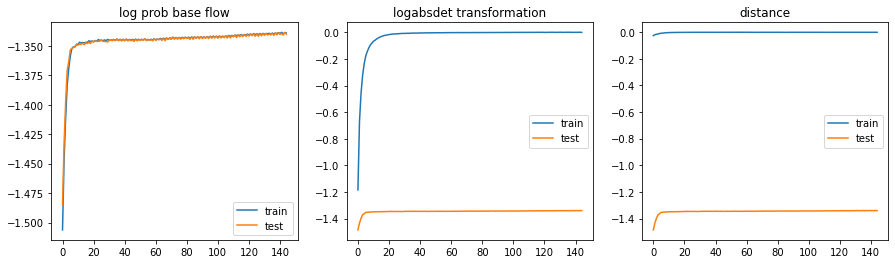

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


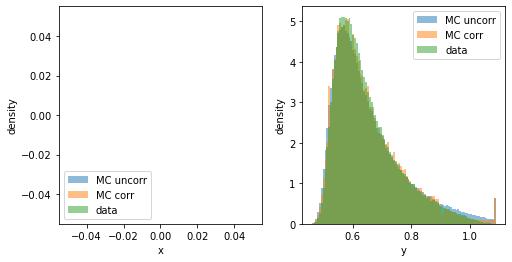

145
146
147
148


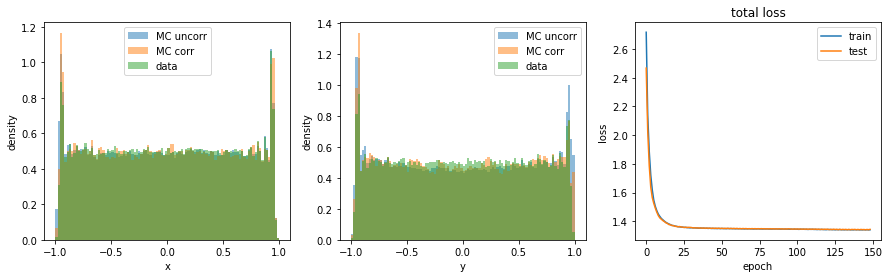

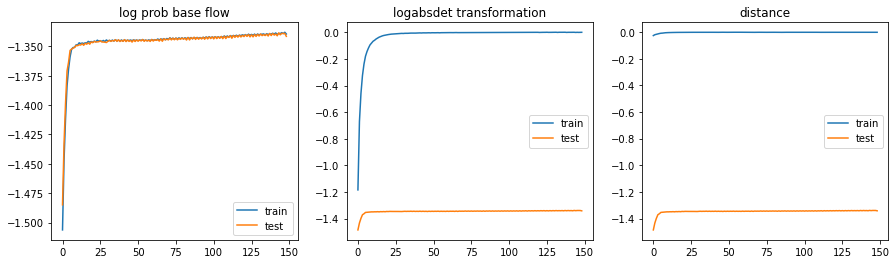

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


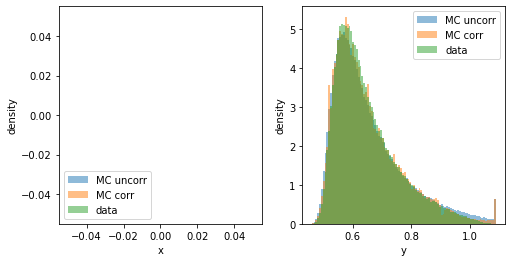

149
150
151
152


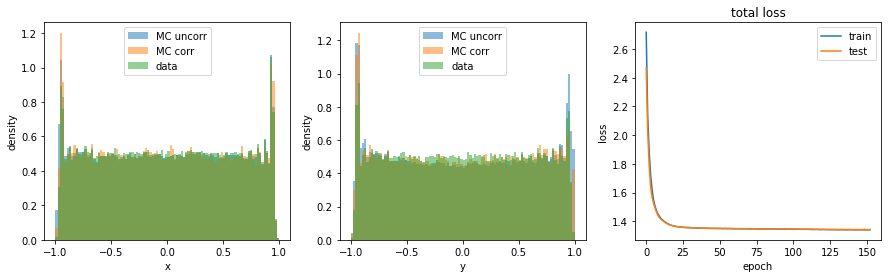

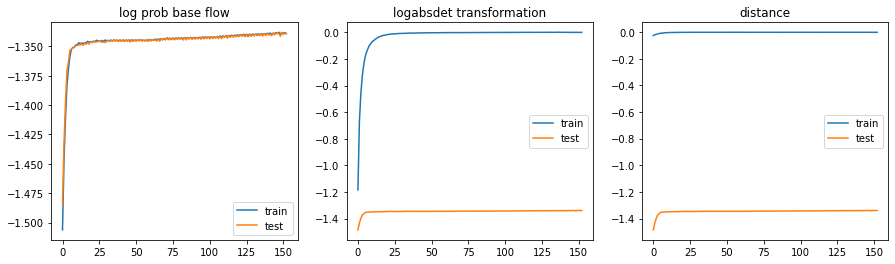

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


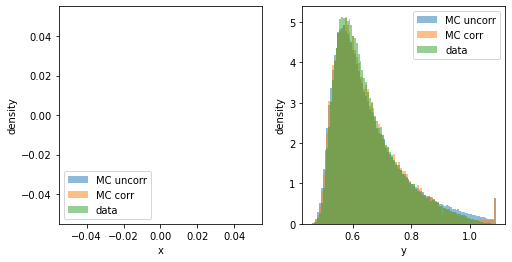

153
154
155
156


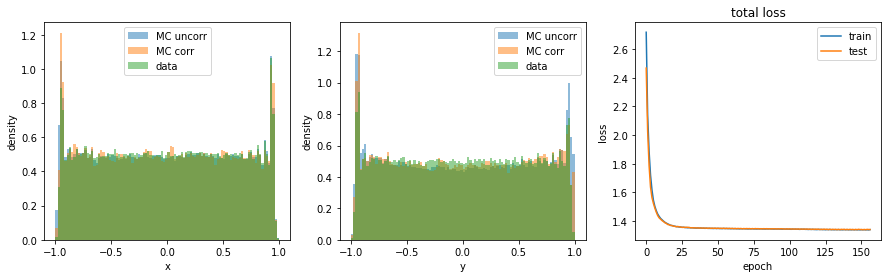

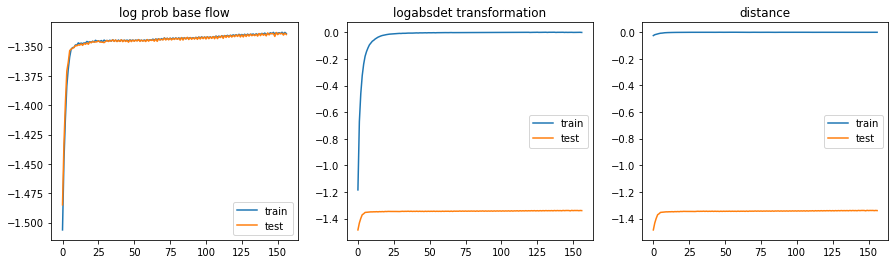

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


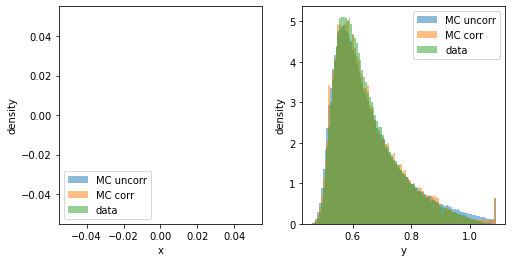

157
158
159
160


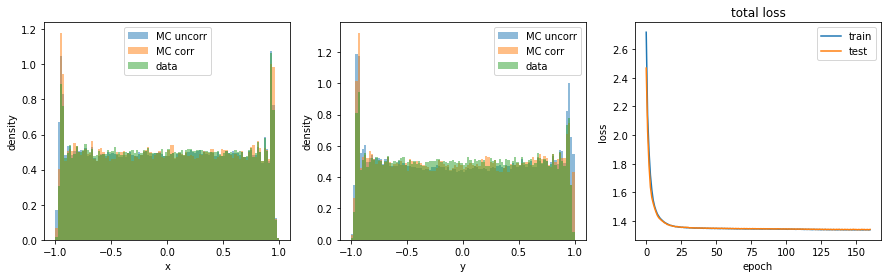

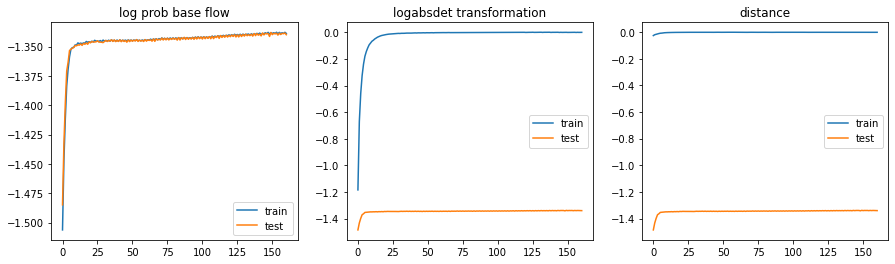

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


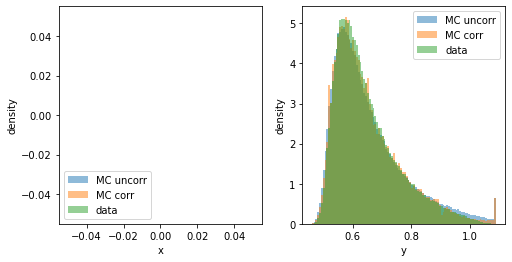

161
162
163
164


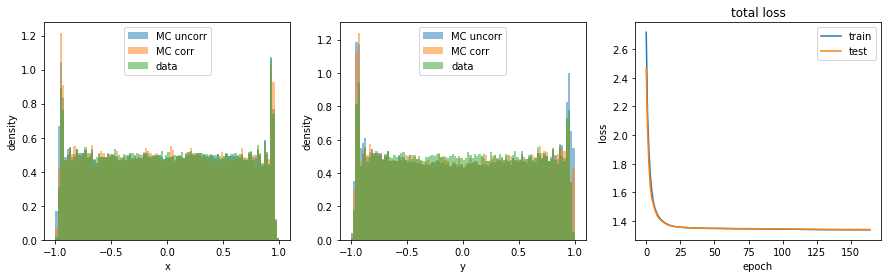

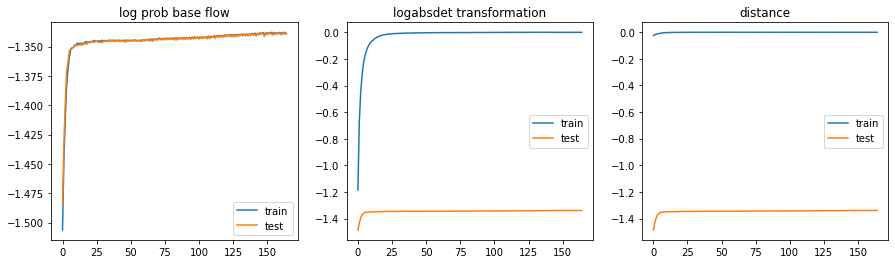

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


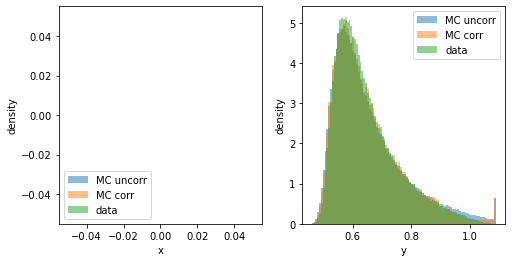

165
166
167
168


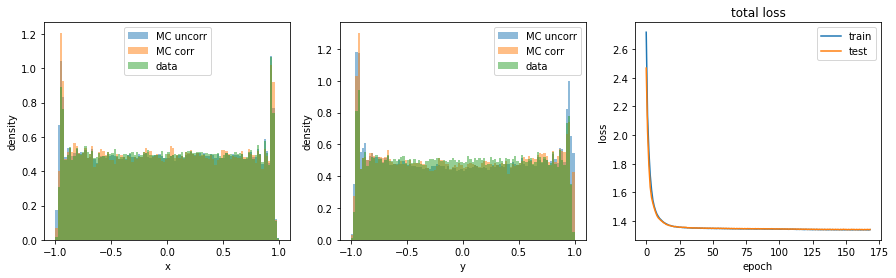

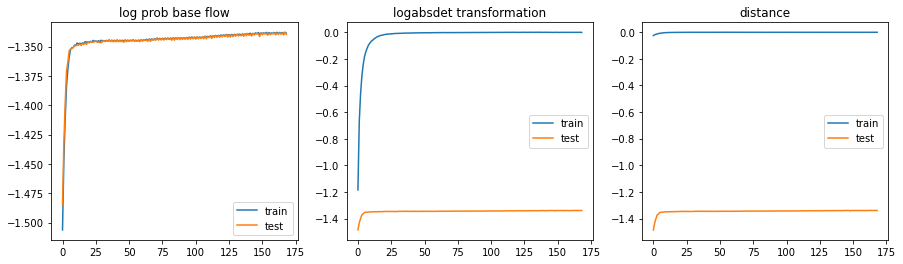

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


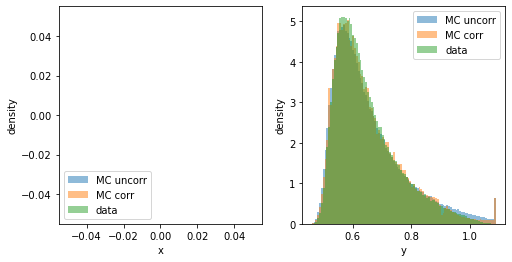

169
170
171
172


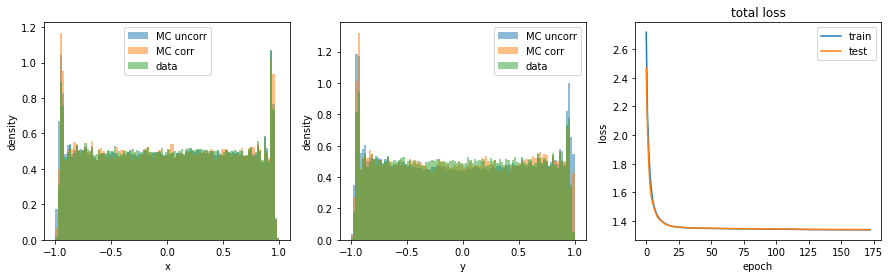

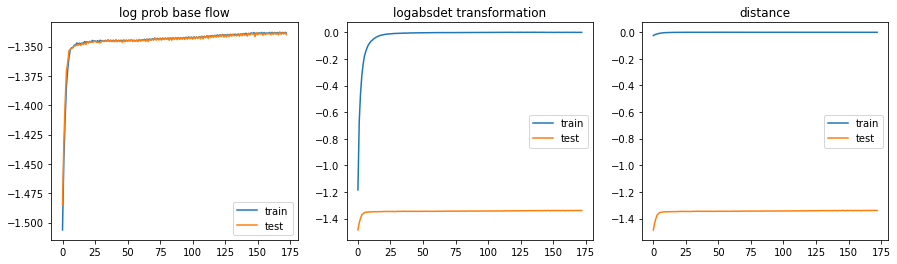

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


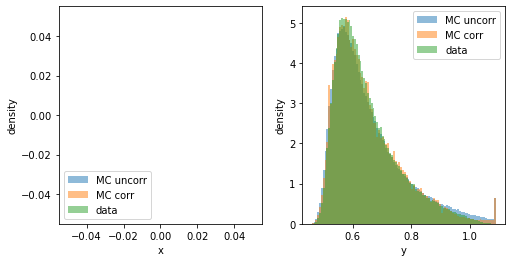

173
174
175
176


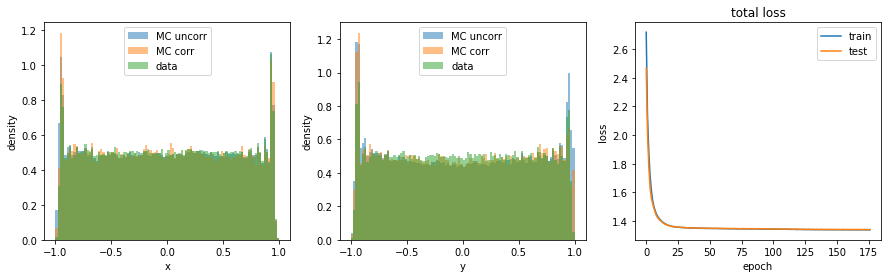

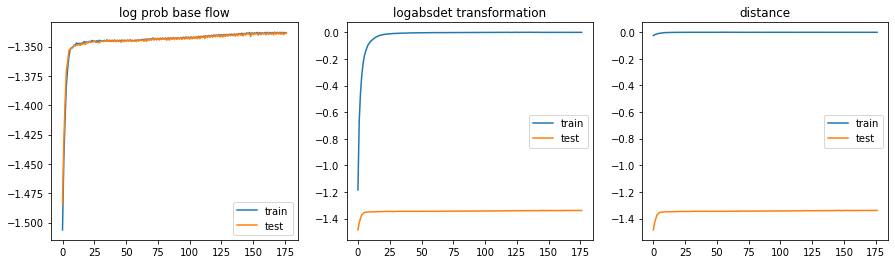

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


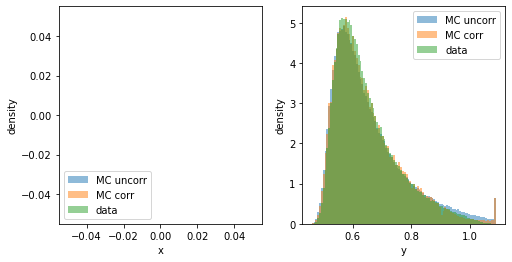

177
178
179
180


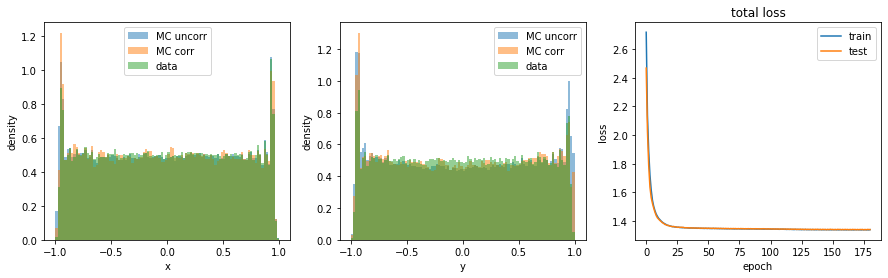

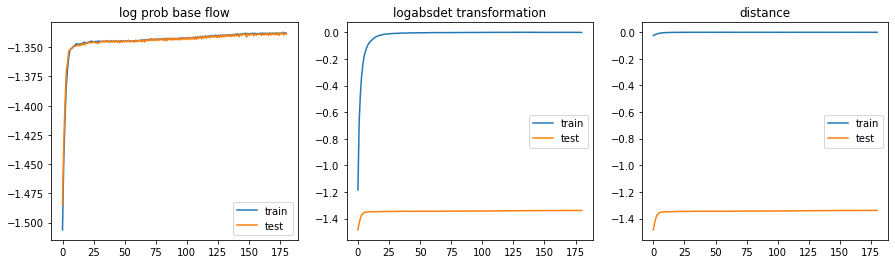

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


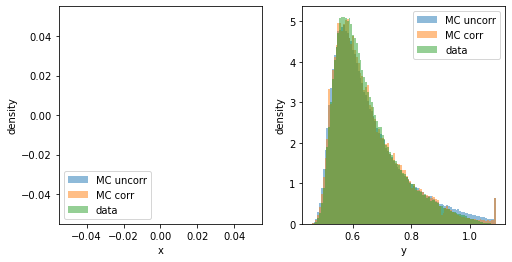

181
182
183
184


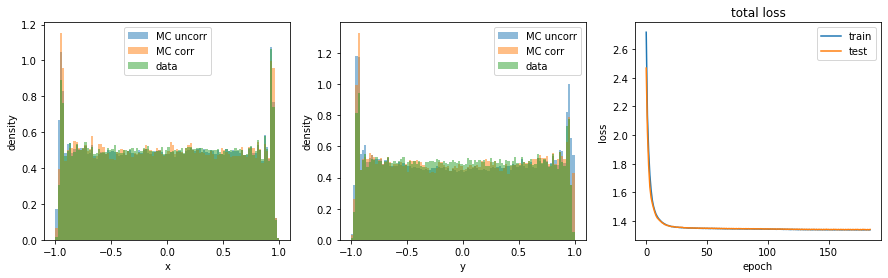

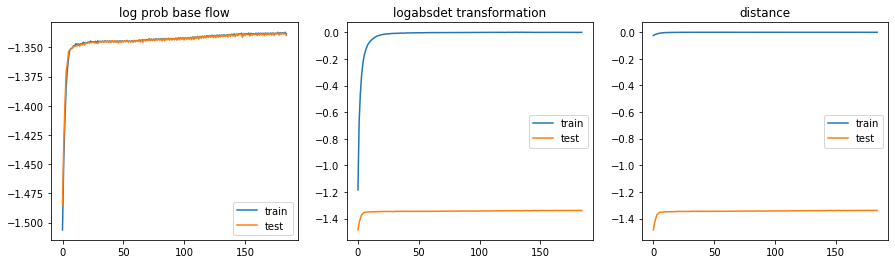

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


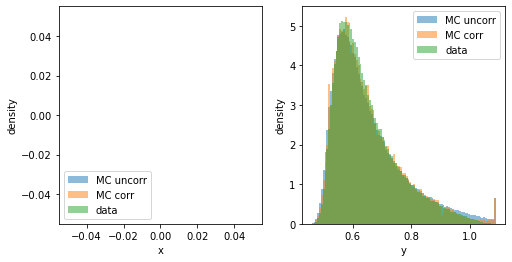

185
186
187
188


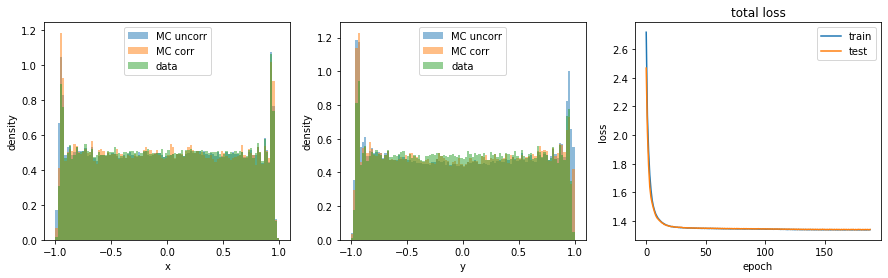

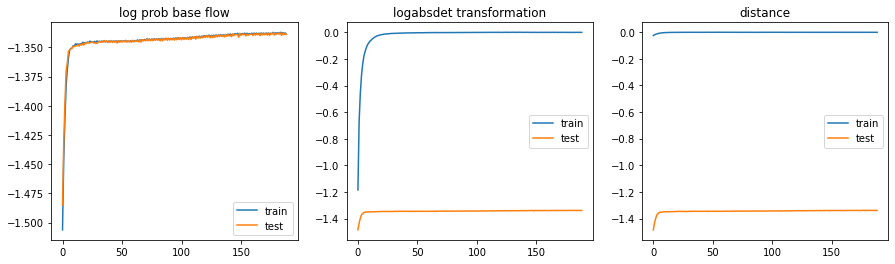

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


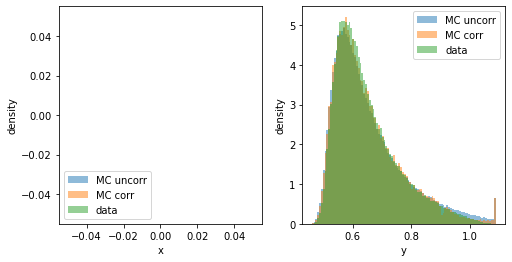

189
190
191
192


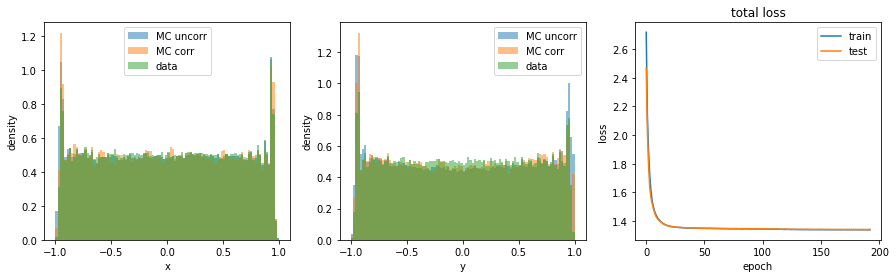

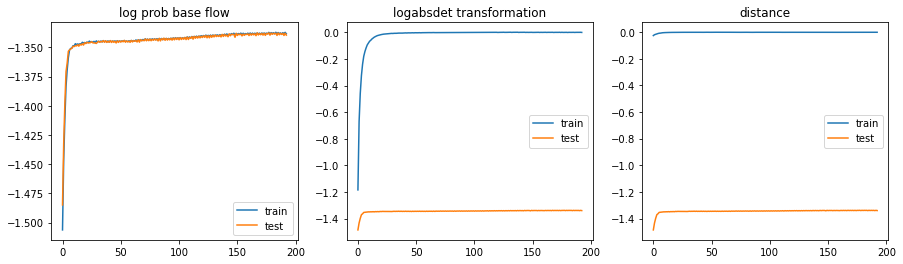

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


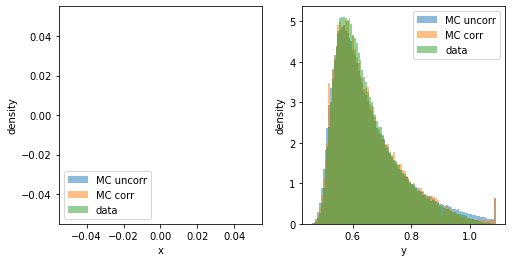

193
194
195
196


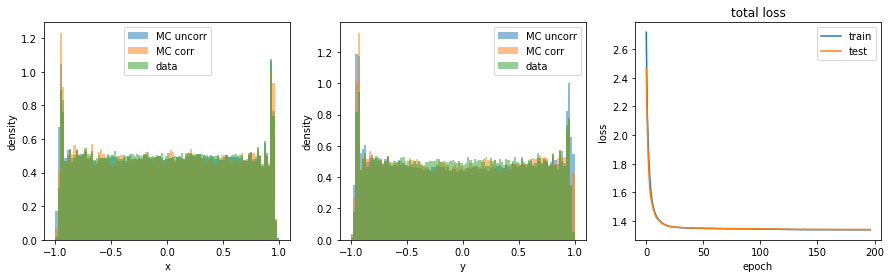

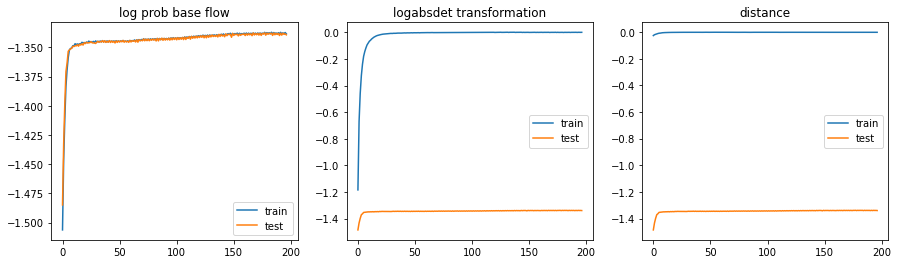

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


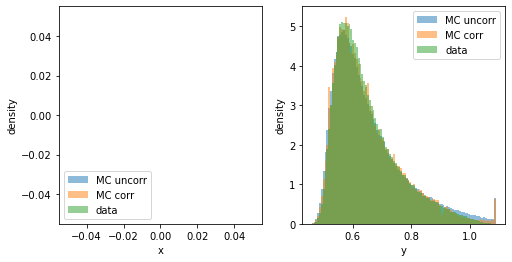

197
198
199


In [17]:
epochs = 200
batch_size = 512
plot_every = 4

train_history, test_history = [], []
train_history1, test_history1 = [], []
train_history2, test_history2 = [], []
train_history3, test_history3 = [], []
for epoch in range(epochs):
    print(epoch)
    epoch_is_even = epoch % 2 == 0
    train_losses, test_losses = [], []
    train_losses1, test_losses1 = [], []
    train_losses2, test_losses2 = [], []
    train_losses3, test_losses3 = [], []
    # train
    for i, (data, mc) in enumerate(zip(data_loader_train, mc_loader_train)):
        if i % 2 == 0 + int(epoch_is_even):
            inverse = False
            ab, xy = mc
        else:
            inverse = True
            ab, xy = data
        optimizer.zero_grad()
        loss1, loss2, loss3 = fffmodel.log_prob(xy, ab, inverse=inverse)
        loss = - (loss1 + loss2 + loss3)
        loss = loss.mean()
        loss1 = loss1.mean()
        loss2 = loss2.mean()
        loss3 = loss3.mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
        train_losses1.append(loss1.item())
        train_losses2.append(loss2.item())
        train_losses3.append(loss3.item())
    train_history.append(np.mean(train_losses))
    train_history1.append(np.mean(train_losses1))
    train_history2.append(np.mean(train_losses2))
    train_history3.append(np.mean(train_losses3))
    
    # test
    for i, (data, mc) in enumerate(zip(data_loader_test, mc_loader_test)):
        if i % 2 == 0 + int(epoch_is_even):
            inverse = False
            ab, xy = mc
        else:
            inverse = True
            ab, xy = data
        with torch.no_grad():
            loss1, loss2, loss3 = fffmodel.log_prob(xy, ab, inverse=inverse)
            loss = - (loss1 + loss2 + loss3)
            loss = loss.mean()
            loss1 = loss1.mean()
            loss2 = loss2.mean()
            loss3 = loss3.mean()
            test_losses.append(loss.item()) 
            test_losses1.append(loss1.item())
            test_losses2.append(loss2.item())
            test_losses3.append(loss3.item())
    test_history.append(np.mean(test_losses))
    test_history1.append(np.mean(test_losses1))
    test_history2.append(np.mean(test_losses2))
    test_history3.append(np.mean(test_losses3))

    if epoch % plot_every == 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        ab = torch.tensor(df_test[['a', 'b']].values, dtype=torch.float32).to(device)
        xy_mc_uncorr = torch.tensor(df_test[['x', 'y']].values, dtype=torch.float32).to(device)
        xy_mc_corr = fffmodel.transform(xy_mc_uncorr, ab, inverse=False)
        x_mc_uncorr, y_mc_uncorr = xy_mc_uncorr[:, 0].detach().cpu().numpy(), xy_mc_uncorr[:, 1].detach().cpu().numpy()
        x_mc_corr, y_mc_corr = xy_mc_corr[0][:, 0].detach().cpu().numpy(), xy_mc_corr[0][:, 1].detach().cpu().numpy()
        x_data, y_data = df_target_test['x'].values, df_target_test['y'].values
        # plot
        x_min = min(x_mc_uncorr.min(), x_mc_corr.min(), x_data.min())
        x_max = max(x_mc_uncorr.max(), x_mc_corr.max(), x_data.max())
        ax1.hist(x_mc_uncorr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC uncorr')
        ax1.hist(x_mc_corr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC corr')
        ax1.hist(x_data, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='data')
        ax1.set_xlabel('x')
        ax1.set_ylabel('density')
        ax1.legend()
        y_min = min(y_mc_uncorr.min(), y_mc_corr.min(), y_data.min())
        y_max = max(y_mc_uncorr.max(), y_mc_corr.max(), y_data.max())
        ax2.hist(y_mc_uncorr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC uncorr')
        ax2.hist(y_mc_corr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC corr')
        ax2.hist(y_data, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='data')
        ax2.set_xlabel('y')
        ax2.set_ylabel('density')
        ax2.legend()
        ax3.plot(train_history, label='train')
        ax3.plot(test_history, label='test')
        ax3.set_xlabel('epoch')
        ax3.set_ylabel('loss')
        ax3.set_title('total loss')
        ax3.legend()
        plt.show()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        ax1.plot(train_history1, label='train')
        ax1.plot(test_history1, label='test')
        ax1.set_title('log prob base flow')
        ax1.legend()
        ax2.plot(train_history2, label='train')
        ax2.plot(test_history1, label='test')
        ax2.set_title('logabsdet transformation')
        ax2.legend()
        ax3.plot(train_history3, label='train')
        ax3.plot(test_history1, label='test')
        ax3.set_title('distance')
        ax3.legend()
        plt.show()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        x_data = pipelines['x'].inverse_transform(x_data.reshape(-1, 1))
        x_mc_corr = pipelines['x'].inverse_transform(x_mc_corr.reshape(-1, 1))
        x_mc_uncorr = pipelines['x'].inverse_transform(x_mc_uncorr.reshape(-1, 1))
        y_data = pipelines['y'].inverse_transform(y_data.reshape(-1, 1))
        y_mc_corr = pipelines['y'].inverse_transform(y_mc_corr.reshape(-1, 1))
        y_mc_uncorr = pipelines['y'].inverse_transform(y_mc_uncorr.reshape(-1, 1))        
        ax1.hist(x_mc_uncorr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC uncorr')
        ax1.hist(x_mc_corr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC corr')
        ax1.hist(x_data, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='data')
        ax1.set_xlabel('x')
        ax1.set_ylabel('density')
        ax1.legend()
        y_min = min(y_mc_uncorr.min(), y_mc_corr.min(), y_data.min())
        y_max = max(y_mc_uncorr.max(), y_mc_corr.max(), y_data.max())
        ax2.hist(y_mc_uncorr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC uncorr')
        ax2.hist(y_mc_corr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC corr')
        ax2.hist(y_data, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='data')
        ax2.set_xlabel('y')
        ax2.set_ylabel('density')
        ax2.legend()    
        plt.show()